In [268]:
# Suzan Iloglu, Dec 11,2020
# Positive results from Pfizer, Moderna and AstraZeneca show a vaccine can work
# In this research, we wanna show the allocation of vaccine over the us by states and then by counties
# Import packages
import csv

from itertools import product
import geopandas as gpd
import pandas as pd
import numpy as np
import math
import time
import requests
import io
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
pd.options.display.max_columns =200
from IPython.display import Image
import sodapy
from sodapy import Socrata


# MAPPING THE VACCINE ALLOCATION
The project presents multiple options for how to distribute vaccine within each county per state. It shows that what you choose to prioritize greatly impacts where care would be sent. 
The followings are our options to choose to define vulnerability:


- SOCIAL VULNERABILITY INDEX
- MEDICAID 
- UNEMPLOYMENT
- YEARS OF POTENTIAL LIFE LOST
- TOTAL COVID CASES
- COVID CASES BY POPULATION
- COVID DEATHS BY POPULATION

We will start with Social Vulnerability Index (SVI) from CDC website.

### I. Importing SVI data which includes the variables for calculating county SVI for each state
The CDC uses both a USA-wide and a state by state SVI scores. For our project given that funding is likely going to be managed at a state level, using a state by state SVI scores makes the most sense and will be most sensitive to regional socioeconomic differences. Even though the CDC SVI scores are calculated using percentile rankings, the data sets include raw data estimates for each variables. The following table shows the variablaes used in the method of calculating SVI scores. 




      American Community Survey (ACS), 2015-2019 (5-year) data for the following estimates:
<img src="Data/img/SVI_comp.png" width="500">


Note: Full documentation for 2018 data is available <a href="https://svi.cdc.gov/data-and-tools-download.html">here</a> 
This part of the code shows preliminary mapping of <a href = "https://svi.cdc.gov/">the CDC's Social Vulnerability Index</a>.

Later in the notebook, we will provide the formula to create the SVI value we use in our project. First, we import the data for the US mainland and Puerto Rico.

In [269]:
## import svi data downloaded from CDC website as cited above

## 48 state SVI scores by county
#svi_counties_mainland = gpd.read_file("Data/SVI2018_US_COUNTY/SVI2018_US_county.shp")

## Puerto Rico SVI scores by county
#svi_counties_puerto_rico = gpd.read_file("Data/PuertoRico_COUNTY/SVI2018_PuertoRico_county.shp")

## Merge 48 states and Puerto Rico SVI 
#svi_counties = pd.concat([svi_counties_mainland,svi_counties_puerto_rico ], sort = False)
svi_counties =  pd.read_csv('Input/SVI_2019_State_Data.csv')
svi_counties.head(5)

,ST,COUNTY,STATE,FIPS,AREA_SQMI,E_TOTPOP,M_TOTPOP,E_HU,M_HU,E_HH,M_HH,E_POV,M_POV,E_UNEMP,M_UNEMP,E_PCI,M_PCI,E_NOHSDP,M_NOHSDP,E_AGE65,M_AGE65,E_AGE17,M_AGE17,E_DISABL,M_DISABL,E_SNGPNT,M_SNGPNT,E_MINRTY,M_MINRTY,E_LIMENG,M_LIMENG,E_MUNIT,M_MUNIT,E_MOBILE,M_MOBILE,E_CROWD,M_CROWD,E_NOVEH,M_NOVEH,E_GROUPQ,M_GROUPQ,EP_POV,MP_POV,EP_UNEMP,MP_UNEMP,EP_PCI,MP_PCI,EP_NOHSDP,MP_NOHSDP,EP_AGE65,MP_AGE65,EP_AGE17,MP_AGE17,EP_DISABL,MP_DISABL,EP_SNGPNT,MP_SNGPNT,EP_MINRTY,MP_MINRTY,EP_LIMENG,MP_LIMENG,EP_MUNIT,MP_MUNIT,EP_MOBILE,MP_MOBILE,EP_CROWD,MP_CROWD,EP_NOVEH,MP_NOVEH,EP_GROUPQ,MP_GROUPQ,EPL_POV,EPL_UNEMP,EPL_PCI,EPL_NOHSDP,SPL_THEME1,RPL_THEME1,EPL_AGE65,EPL_AGE17,EPL_DISABL,EPL_SNGPNT,SPL_THEME2,RPL_THEME2,EPL_MINRTY,EPL_LIMENG,SPL_THEME3,RPL_THEME3,EPL_MUNIT,EPL_MOBILE,EPL_CROWD,EPL_NOVEH,EPL_GROUPQ,SPL_THEME4,RPL_THEME4,SPL_THEMES,RPL_THEMES,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR
0,1,Autauga County,Alabama,1001,594.4435,55380.0,NaN,23493,83,21397.0,325.0,8340,1000,936,246,29819,2345,4291.0,516.0,8283,85.0,13205,39.0,54552.0,232.0,947.0,188.2180,14065.0,NaN,419,228.2236,834,279.9589,4414,413,243,119.5073,941,198,565,162.0,15.2,1.8,3.7,1.0,29819,2345,11.5,1.4,15.0,0.2,23.8443,NaN,54552.0,NaN,4.4259,0.8771,25.3973,NaN,0.8033,0.4375,3.5500,1.1916,18.8,1.8,1.1357,0.5583,4.4,0.9,1.0202,NaN,0.2121,0.0606,0.0606,0.0758,0.4091,0.0455,0.1212,0.8939,0.6515,0.1515,1.8182,0.3182,0.4091,0.6667,1.0758,0.5455,0.7727,0.3636,0.2273,0.1364,0.1818,1.6818,0.0909,4.9848,0.0303,3856,561,7.1,1.0
1,1,Baldwin County,Alabama,1003,1589.8220,212830.0,NaN,114164,219,80930.0,1127.0,21704,1794,4226,580,32626,758,13893.0,1077.0,42531,194.0,46235,NaN,210305.0,474.0,4200.0,474.9874,36027.0,NaN,1425,486.4638,19766,1075.4023,12666,762,1042,301.4797,2656,360,3008,438.0,10.4,0.9,4.3,0.6,32626,758,9.2,0.7,20.0,0.1,21.7239,NaN,210305.0,NaN,5.1897,0.5824,16.9276,NaN,0.7085,0.2419,17.3137,0.9414,11.1,0.7,1.2875,0.3721,3.3,0.4,1.4133,NaN,0.0152,0.1364,0.0303,0.0455,0.2273,0.0152,0.7727,0.4091,0.9242,0.4394,2.5455,0.9697,0.2121,0.5909,0.8030,0.3182,1.0000,0.1364,0.3182,0.0455,0.4242,1.9242,0.1667,5.5000,0.0606,18679,1449,8.9,0.7
2,1,Barbour County,Alabama,1005,885.0076,25361.0,NaN,12013,143,9345.0,313.0,6875,558,849,176,18473,942,4812.0,333.0,4710,38.0,5307,27.0,22475.0,339.0,444.0,105.8017,13743.0,NaN,454,170.5696,208,86.0233,3520,255,360,157.1751,950,184,2886,339.0,30.7,2.4,9.2,1.9,18473,942,26.8,1.8,18.6,0.1,20.9258,NaN,22475.0,NaN,4.7512,1.1209,54.1895,NaN,1.8907,0.7103,1.7315,0.7158,29.3,2.0,3.8523,1.6770,10.2,2.0,11.3797,NaN,0.9545,0.7879,0.9394,1.0000,3.6818,0.9697,0.5152,0.1970,0.3636,0.3030,1.3788,0.0606,0.8333,0.9242,1.7576,1.0000,0.5000,0.8182,0.9697,0.8182,0.9848,4.0909,1.0000,10.9091,0.9848,2544,342,11.3,1.5
3,1,Bibb County,Alabama,1007,622.4611,22493.0,NaN,9185,68,6891.0,333.0,3740,939,659,248,20778,1703,3386.0,515.0,3584,61.0,4631,38.0,20632.0,201.0,356.0,133.0564,5730.0,NaN,71,103.0388,240,135.3255,2890,310,77,48.7545,425,170,1893,201.0,18.1,4.5,7.3,2.8,20778,1703,20.9,3.2,15.9,0.3,20.5886,NaN,20632.0,NaN,5.1662,1.9147,25.4746,NaN,0.3353,0.4865,2.6130,1.4732,31.5,3.4,1.1174,0.7054,6.2,2.4,8.4160,NaN,0.4545,0.6212,0.8333,0.8636,2.7727,0.7727,0.1818,0.1212,0.3182,0.4091,1.0303,0.0152,0.4242,0.3030,0.7273,0.2424,0.6364,0.8788,0.2121,0.5152,0.9394,3.1818,0.8788,7.7121,0.6061,2201,466,10.7,2.2
4,1,Blount County,Alabama,1009,644.8304,57681.0,NaN,24323,67,20847.0,394.0,7739,967,763,206,24747,1318,7763.0,647.0,10326,108.0,13389,56.0,57217.0,131.0,1117.0,219.6178,7560.0,NaN,878,245.7885,197,104.5610,6150,395,374,106.2309,860,221,551,124.0,13.6,1.7,3.4,0.9,24747,1318,19.5,1.6,17.9,0.2,23.2121,NaN,57217.0,NaN,5.3581,1.0486,13.1066,NaN,1.6185,0.4531,0.8099,0.4299,25.3,1.6,1.7940,0.5084,4.1,1.1,0.9553,NaN,0.0909,0.0152,0.3485,0.7121,1.1667,0.2121,0.4242,0.7879,0.6818,0.5455,2.4394,0.8788,0.1061,0.8788,0.9848,0.4697,0.2273,0.6364,0.6364,0.0909,0.1364,1.7273,0.1212,6.3182,0.1818,6159,810,10.8,1.4


In [270]:
## Create the list for State
S = svi_counties.STATE.unique().tolist()
if "0" in S:
    S.remove(0)
State = [str(s).strip() for s in S]
State

['Alabama',
 'Alaska',
 'Arizona',
 'Arkansas',
 'California',
 'Colorado',
 'Connecticut',
 'Delaware',
 'District of Columbia',
 'Florida',
 'Georgia',
 'Hawaii',
 'Idaho',
 'Illinois',
 'Indiana',
 'Iowa',
 'Kansas',
 'Kentucky',
 'Louisiana',
 'Maine',
 'Maryland',
 'Massachusetts',
 'Michigan',
 'Minnesota',
 'Mississippi',
 'Missouri',
 'Montana',
 'Nebraska',
 'Nevada',
 'New Hampshire',
 'New Jersey',
 'New Mexico',
 'New York',
 'North Carolina',
 'North Dakota',
 'Ohio',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'Rhode Island',
 'South Carolina',
 'South Dakota',
 'Tennessee',
 'Texas',
 'Utah',
 'Vermont',
 'Virginia',
 'Washington',
 'West Virginia',
 'Wisconsin',
 'Wyoming',
 'Puerto Rico']

In [271]:
## Replacing -999 values with 0 for calculations
svi_county = svi_counties.fillna(0)
svi_county  = svi_county.replace(-999, 0)
svi_county['FIPS'] = svi_county['FIPS'].astype(int)
svi_county.shape

(3220, 100)

In [272]:
# Create a seperate dictionary for the variables to calculate SVI

# Persons below poverty estimate, 2014-2018 ACS
E_POV = dict(zip(svi_county.FIPS, svi_county.E_POV))

# Civilian (age 16+) unemployed estimate, 2014-2018 ACS
E_UNEMP = dict(zip(svi_county.FIPS, svi_county.E_UNEMP))

# Per capita income estimate, 2014-2018 ACS
E_PCI = dict(zip(svi_county.FIPS, svi_county.E_PCI))

# Persons (age 25+) with no high school diploma estimate, 2014-2018 ACS
E_NOHSDP = dict(zip(svi_county.FIPS, svi_county.E_NOHSDP))

# Persons aged 65 and older estimate
E_AGE65 = dict(zip(svi_county.FIPS, svi_county.E_AGE65))

# Persons aged 17 and younger estimate
E_AGE17 = dict(zip(svi_county.FIPS, svi_county.E_AGE17))

# Population with a disability estimate
E_DISABL = dict(zip(svi_county.FIPS, svi_county.E_DISABL))

# Single parent households with children under 18 estimate
E_SNGPNT = dict(zip(svi_county.FIPS, svi_county.E_SNGPNT))

# Minority (all persons except white, nonHispanic) estimate, 2014-2018 ACS
E_MINRTY = dict(zip(svi_county.FIPS, svi_county.E_MINRTY))

# Persons (age 5+) who speak English "less than well" estimate, 2014-2018 ACS
E_LIMENG = dict(zip(svi_county.FIPS, svi_county.E_LIMENG))

# Housing in structures with 10 or more units estimate, 2014-2018 ACS
E_MUNIT = dict(zip(svi_county.FIPS, svi_county.E_MUNIT))

# Mobile homes estimate MOE, 2014-2018 ACS
E_MOBILE = dict(zip(svi_county.FIPS, svi_county.E_MOBILE))

# At household level (occupied housing units), more people than rooms estimate, 2014-2018 ACS
E_CROWD = dict(zip(svi_county.FIPS, svi_county.E_CROWD))

# Households with no vehicle available estimate, 2014-2018 ACS
E_NOVEH = dict(zip(svi_county.FIPS, svi_county.E_NOVEH))

# Persons in institutionalized group quarters estimate, 2014-2018 ACS
E_GROUPQ = dict(zip(svi_county.FIPS, svi_county.E_GROUPQ))

# Percentage of persons below poverty estimate
E_POV = dict(zip(svi_county.FIPS, svi_county.E_POV))

In [273]:
df_mmm = pd.read_csv("Input/ACSST5Y2019.S2704_data_with_overlays_2020-12-11T225641.csv", header=[1])
df_mmm.head(1)
#df_mmm.dtypes

,id,Geographic Area Name,Estimate!!Total!!Civilian noninstitutionalized population,Margin of Error!!Total!!Civilian noninstitutionalized population,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicare coverage alone or in combination,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicare coverage alone or in combination,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicare coverage alone or in combination!!Under 19,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicare coverage alone or in combination!!Under 19,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicare coverage alone or in combination!!19 to 64 years,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicare coverage alone or in combination!!19 to 64 years,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicare coverage alone or in combination!!65 years and over,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicare coverage alone or in combination!!65 years and over,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicaid/means-tested public coverage alone or in combination,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicaid/means-tested public coverage alone or in combination,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicaid/means-tested public coverage alone or in combination!!Under 19,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicaid/means-tested public coverage alone or in combination!!Under 19,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicaid/means-tested public coverage alone or in combination!!19 to 64 years,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicaid/means-tested public coverage alone or in combination!!19 to 64 years,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicaid/means-tested public coverage alone or in combination!!65 years and over,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!Medicaid/means-tested public coverage alone or in combination!!65 years and over,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!VA health care coverage alone or in combination,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!VA health care coverage alone or in combination,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!VA health care coverage alone or in combination!!Under 19,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!VA health care coverage alone or in combination!!Under 19,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!VA health care coverage alone or in combination!!19 to 64 years,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!VA health care coverage alone or in combination!!19 to 64 years,Estimate!!Total!!COVERAGE ALONE OR IN COMBINATION!!VA health care coverage alone or in combination!!65 years and over,Margin of Error!!Total!!COVERAGE ALONE OR IN COMBINATION!!VA health care coverage alone or in combination!!65 years and over,Estimate!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!Below 138 percent of the poverty threshold,Margin of Error!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!Below 138 percent of the poverty threshold,Estimate!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!At or above 138 percent of the poverty threshold,Margin of Error!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!At or above 138 percent of the poverty threshold,"Estimate!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!Worked full-time, year-round (19-64 years)","Margin of Error!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!Worked full-time, year-round (19-64 years)",Estimate!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!Under 6,Margin of Error!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!Under 6,Estimate!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!6 to 18 years,Margin of Error!!Total!!PUBLIC HEALTH INSURANCE ALONE OR IN COMBINATION!!6 to 18 years,Estimate!!Total!!PUBLIC HEALTH INSURANCE ALON

In [274]:

pandemic_i = pd.read_csv("https://raw.githubusercontent.com/COVID19PVI/data/master/Model11.2.1/Model_11.2.1_20201215_results.csv")

#pandemic_index[['Name','NAME']] = pandemic_index['Name'].str.split(',',expand=True)
pandemic_i.head(5)

,ToxPi Score,HClust Group,KMeans Group,Name,Source,Infection Rate: Transmissible Cases!25!0xcc3333ff,Infection Rate: Disease Spread!5!0xe64d4dff,Pop Concentration: Pop Mobility!10!0x57b757ff,Pop Concentration: Residential Density!10!0x5ced5cff,Intervention: Social Distancing!10!0x4258c9ff,Intervention: Testing!10!0x6079f7ff,Health & Environment: Pop Demographics!10!0x6b0b9eff,Health & Environment: Air Pollution!10!0x8e26c4ff,Health & Environment: Age Distribution!10!0x9a42c8ff,Health & Environment: Co-morbidities!10!0xb460e0ff,Health & Environment: Health Disparities!10!0xc885ecff,Health & Environment: Hospital Beds!5!0xdeb9f1ff
0,0.638253,7,1,"Mississippi, Neshoba","-89.1173,32.7534",0.673873,0.164261,0.540407,0.8316,0.750,0.766526,0.907980,0.443114,0.521532,0.607214,0.612941,0.460080
1,0.635230,7,8,"Alabama, Talladega","-86.1689,33.3782",0.645233,0.220816,0.578332,0.7985,1.000,0.867080,0.597357,0.508982,0.560557,0.560892,0.541342,0.407683
2,0.634814,7,8,"Virginia, Galax City","-80.917,36.666",0.731868,0.200097,0.703484,0.9188,1.000,0.746181,0.441340,0.335329,0.666136,0.473758,0.628630,0.183602
3,0.634474,7,8,"Kansas, Wyandotte","-94.7638,39.1173",0.681493,0.186529,0.713249,0.6686,1.000,0.938396,0.674713,0.425150,0.419125,0.474933,0.657392,0.324750
4,0.628516,7,1,"Mississippi, Leake","-89.524,32.7537",0.657959,0.182865,0.451002,0.9220,0.675,0.766526,0.881904,0.425150,0.511724,0.536734,0.673518,0.553126


In [275]:
pandemic_input = pd.read_csv("https://raw.githubusercontent.com/COVID19PVI/data/master/Model11.2.1/Model_11.2.1_20201216_data.csv", header = [12])


pandemic_input.head(5)


,row,sid,casrn,name,Spread,Sick,PctCases,Cases,CountyCaseRate,StateCaseRate,PctDeaths,Deaths,PctDeaths2,CountyDeathRate,StateDeathRate,StatePctTested,StateTestRate,SVISocioeconomic,SVIMinority,SVIHousing,PctBeds,Mobility,PctNoIns,PctGE65,DaytimePopDensity,PrematureDeath,Smoking,AirPollution,Diabetes,Traffic,DistancingGrade,Obesity,PctBlack,PctNative
0,1,"-86.6441,32.5395",1001,"Alabama, Autauga",0.177466,10.935055,0.061618,3426,1.014996,1.012372,0.012551,43,0.000773,1.006827,1.006616,0.354384,1.005746,0.3631,0.5947,0.3741,0.001529,1733.08,7.1,14.6,76.0,8128.591190,0.180816,11.7,0.111,88.457040,5.0,0.333,0.193432,0.004802
1,2,"-87.7221,30.7277",1003,"Alabama, Baldwin",0.181720,9.219253,0.050733,11061,1.014887,1.012372,0.012747,141,0.000647,1.000000,1.006616,0.354384,1.005746,0.2232,0.4358,0.3359,0.001523,1971.57,10.2,19.5,121.0,7354.122530,0.174890,10.3,0.107,86.997430,5.0,0.310,0.087840,0.007724
2,3,"-85.3871,31.8683",1005,"Alabama, Barbour",0.079721,4.139705,0.051927,1292,1.005886,1.012372,0.023220,30,0.001206,1.000000,1.006616,0.354384,1.005746,0.9780,0.8558,0.9889,0.002974,1080.54,11.2,18.0,27.5,10253.573403,0.220000,11.5,0.176,102.291762,3.7,0.417,0.480326,0.006591
3,4,"-87.1251,32.9964",1007,"Alabama, Bibb",0.199468,13.392857,0.067143,1504,1.019148,1.012372,0.025931,39,0.001741,1.000000,1.006616,0.354384,1.005746,0.7694,0.4323,0.7189,0.001563,1272.47,7.9,16.3,28.9,11977.539484,0.191142,11.2,0.145,29.335580,4.0,0.376,0.211205,0.004375
4,5,"-86.5679,33.9821",1009,"Alabama, Blount",0.211286,14.177040,0.067099,3881,1.017974,1.012372,0.012626,49,0.000847,1.009066,1.006616,0.354384,1.005746,0.6143,0.5915,0.1741,0.000692,1395.46,11.0,17.8,71.7,11335.071134,0.192087,11.7,0.170,33.411782,4.3,0.338,0.014627,0.006535


In [276]:
pandemic_in = pd.merge(left = pandemic_i, right = pandemic_input[['sid', 'casrn']], how = 'left', left_on = 'Source', right_on = 'sid')

pandemic_in.head(5)



,ToxPi Score,HClust Group,KMeans Group,Name,Source,Infection Rate: Transmissible Cases!25!0xcc3333ff,Infection Rate: Disease Spread!5!0xe64d4dff,Pop Concentration: Pop Mobility!10!0x57b757ff,Pop Concentration: Residential Density!10!0x5ced5cff,Intervention: Social Distancing!10!0x4258c9ff,Intervention: Testing!10!0x6079f7ff,Health & Environment: Pop Demographics!10!0x6b0b9eff,Health & Environment: Air Pollution!10!0x8e26c4ff,Health & Environment: Age Distribution!10!0x9a42c8ff,Health & Environment: Co-morbidities!10!0xb460e0ff,Health & Environment: Health Disparities!10!0xc885ecff,Health & Environment: Hospital Beds!5!0xdeb9f1ff,sid,casrn
0,0.638253,7,1,"Mississippi, Neshoba","-89.1173,32.7534",0.673873,0.164261,0.540407,0.8316,0.750,0.766526,0.907980,0.443114,0.521532,0.607214,0.612941,0.460080,"-89.1173,32.7534",28099
1,0.635230,7,8,"Alabama, Talladega","-86.1689,33.3782",0.645233,0.220816,0.578332,0.7985,1.000,0.867080,0.597357,0.508982,0.560557,0.560892,0.541342,0.407683,"-86.1689,33.3782",1121
2,0.634814,7,8,"Virginia, Galax City","-80.917,36.666",0.731868,0.200097,0.703484,0.9188,1.000,0.746181,0.441340,0.335329,0.666136,0.473758,0.628630,0.183602,"-80.917,36.666",51640
3,0.634474,7,8,"Kansas, Wyandotte","-94.7638,39.1173",0.681493,0.186529,0.713249,0.6686,1.000,0.938396,0.674713,0.425150,0.419125,0.474933,0.657392,0.324750,"-94.7638,39.1173",20209
4,0.628516,7,1,"Mississippi, Leake","-89.524,32.7537",0.657959,0.182865,0.451002,0.9220,0.675,0.766526,0.881904,0.425150,0.511724,0.536734,0.673518,0.553126,"-89.524,32.7537",28079


In [277]:
PVI_county = dict(zip(pandemic_in.casrn, pandemic_in['ToxPi Score']))


In [278]:
ADI =  pd.read_csv('Input/ADI_2019.csv')
ADI.head(5)

,GEOID,NAME,STATE,ADI_US,ADI_ST,ADI_US_Scaled,ADI_ST_Scaled,st,ADI_US_rank,ADI_ST_rank
0,1001,Autauga County,Alabama,90.180531,68.898514,40.14,4.86,1,5,5.0
1,1003,Baldwin County,Alabama,83.132327,55.593936,36.20,4.70,1,2,2.0
2,1005,Barbour County,Alabama,133.749446,129.732504,64.48,5.58,1,64,64.0
3,1007,Bibb County,Alabama,111.576263,100.930506,52.09,5.24,1,33,33.0
4,1009,Blount County,Alabama,101.762939,87.270465,46.61,5.08,1,13,14.0


In [279]:
df_mmm['FIPS'] = df_mmm.id.astype(str).str[9:]
df_mmm.head(5)
df_mmm.FIPS.astype(int)
df_mmm['FIPS'] = pd.to_numeric(df_mmm['FIPS'])

In [280]:
#2019 ADI data
ADI_county  = dict(zip(df_mmm['FIPS'], df_mmm["Estimate!!Public Coverage!!COVERAGE ALONE OR IN COMBINATION!!Medicaid/means-tested public coverage alone or in combination"]))

df_a = pd.read_csv("Input/ACSST5Y2019.S0101_data_with_overlays_2020-12-15T094007.csv", header=[1])
df_a.head(1)


# 2018
# ADI_total  = dict(zip(df_mmm['FIPS'], df_mmm["Estimate!!Public Coverage!!Medicaid/means-tested public coverage alone or in combination"]))

,id,FIPS,Geographic Area Name,Estimate!!Total!!Total population,Margin of Error!!Total!!Total population,Estimate!!Total!!Total population!!AGE!!Under 5 years,Margin of Error!!Total!!Total population!!AGE!!Under 5 years,Estimate!!Total!!Total population!!AGE!!5 to 9 years,Margin of Error!!Total!!Total population!!AGE!!5 to 9 years,Estimate!!Total!!Total population!!AGE!!10 to 14 years,Margin of Error!!Total!!Total population!!AGE!!10 to 14 years,Estimate!!Total!!Total population!!AGE!!15 to 19 years,Margin of Error!!Total!!Total population!!AGE!!15 to 19 years,Estimate!!Total!!Total population!!AGE!!20 to 24 years,Margin of Error!!Total!!Total population!!AGE!!20 to 24 years,Estimate!!Total!!Total population!!AGE!!25 to 29 years,Margin of Error!!Total!!Total population!!AGE!!25 to 29 years,Estimate!!Total!!Total population!!AGE!!30 to 34 years,Margin of Error!!Total!!Total population!!AGE!!30 to 34 years,Estimate!!Total!!Total population!!AGE!!35 to 39 years,Margin of Error!!Total!!Total population!!AGE!!35 to 39 years,Estimate!!Total!!Total population!!AGE!!40 to 44 years,Margin of Error!!Total!!Total population!!AGE!!40 to 44 years,Estimate!!Total!!Total population!!AGE!!45 to 49 years,Margin of Error!!Total!!Total population!!AGE!!45 to 49 years,Estimate!!Total!!Total population!!AGE!!50 to 54 years,Margin of Error!!Total!!Total population!!AGE!!50 to 54 years,Estimate!!Total!!Total population!!AGE!!55 to 59 years,Margin of Error!!Total!!Total population!!AGE!!55 to 59 years,Estimate!!Total!!Total population!!AGE!!60 to 64 years,Margin of Error!!Total!!Total population!!AGE!!60 to 64 years,Estimate!!Total!!Total population!!AGE!!65 to 69 years,Margin of Error!!Total!!Total population!!AGE!!65 to 69 years,Estimate!!Total!!Total population!!AGE!!70 to 74 years,Margin of Error!!Total!!Total population!!AGE!!70 to 74 years,Estimate!!Total!!Total population!!AGE!!75 to 79 years,Margin of Error!!Total!!Total population!!AGE!!75 to 79 years,Estimate!!Total!!Total population!!AGE!!80 to 84 years,Margin of Error!!Total!!Total population!!AGE!!80 to 84 years,Estimate!!Total!!Total population!!AGE!!85 years and over,Margin of Error!!Total!!Total population!!AGE!!85 years and over,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!5 to 14 years,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!5 to 14 years,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!15 to 17 years,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!15 to 17 years,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!Under 18 years,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!Under 18 years,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!18 to 24 years,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!18 to 24 years,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!15 to 44 years,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!15 to 44 years,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!16 years and over,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!16 years and over,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!18 years and over,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!18 years and over,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!21 years and over,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!21 years and over,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!60 years and over,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!60 years and over,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!62 years and over,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!62 years and over,Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!65 years and over,Margin of Error!!Total!!Total population!!SELECTED AGE CATEGORIES!!65 years and over,Estimate!!Total!!Total popul

In [281]:
#Adult population
Sixty_five_plus_pop = dict(zip(df_a['FIPS'], df_a["Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!65 years and over"]))
Sixty_five_plus_pop

{1001: 8283,
 1003: 42531,
 1005: 4710,
 1007: 3584,
 1009: 10326,
 1011: 1640,
 1013: 3900,
 1015: 19738,
 1017: 6470,
 1019: 5811,
 1021: 7052,
 1023: 2922,
 1025: 4679,
 1027: 2698,
 1029: 2899,
 1031: 8550,
 1033: 10644,
 1035: 2746,
 1037: 2430,
 1039: 7726,
 1041: 2609,
 1043: 15116,
 1045: 8081,
 1047: 6809,
 1049: 11883,
 1051: 12053,
 1053: 6566,
 1055: 19257,
 1057: 3438,
 1059: 5304,
 1061: 5275,
 1063: 1773,
 1065: 2777,
 1067: 3785,
 1069: 18052,
 1071: 10113,
 1073: 101785,
 1075: 2983,
 1077: 18228,
 1079: 5998,
 1081: 18696,
 1083: 14328,
 1085: 1856,
 1087: 3614,
 1089: 53151,
 1091: 3729,
 1093: 6288,
 1095: 16093,
 1097: 65339,
 1099: 4100,
 1101: 33107,
 1103: 20412,
 1105: 1772,
 1107: 3739,
 1109: 4946,
 1111: 4622,
 1113: 8029,
 1115: 14317,
 1117: 31716,
 1119: 2234,
 1121: 14052,
 1123: 8505,
 1125: 26673,
 1127: 12191,
 1129: 3047,
 1131: 2026,
 1133: 5075,
 2013: 318,
 2016: 347,
 2020: 30873,
 2050: 1301,
 2060: 87,
 2068: 209,
 2070: 499,
 2090: 9699,
 2100

In [282]:
df_a = df_a.rename(columns = {"Estimate!!Total!!Total population!!SELECTED AGE CATEGORIES!!18 years and over":'Adult_pop'})
df_a.head(5)
df_a.shape


(3220, 459)

In [283]:
#Adult population
Adult_pop_county = dict(zip(df_a['FIPS'], df_a["Adult_pop"]))
Adult_pop_county

{1001: 42175,
 1003: 166595,
 1005: 20054,
 1007: 17862,
 1009: 44292,
 1011: 8120,
 1013: 15373,
 1015: 89666,
 1017: 26595,
 1019: 20658,
 1021: 33420,
 1023: 10322,
 1025: 18841,
 1027: 10559,
 1029: 11533,
 1031: 39403,
 1033: 43218,
 1035: 9790,
 1037: 8956,
 1039: 29037,
 1041: 10738,
 1043: 64148,
 1045: 37892,
 1047: 29720,
 1049: 53800,
 1051: 62915,
 1053: 28769,
 1055: 80579,
 1057: 13014,
 1059: 23582,
 1061: 20599,
 1063: 6440,
 1065: 11355,
 1067: 13537,
 1069: 80349,
 1071: 40870,
 1073: 508503,
 1075: 10835,
 1077: 74247,
 1079: 25875,
 1081: 126764,
 1083: 73144,
 1085: 7808,
 1087: 15460,
 1089: 282589,
 1091: 14918,
 1093: 23592,
 1095: 71756,
 1097: 316303,
 1099: 16522,
 1101: 173501,
 1103: 91846,
 1105: 7286,
 1107: 16212,
 1109: 26863,
 1111: 17751,
 1113: 43783,
 1115: 67948,
 1117: 162807,
 1119: 10327,
 1121: 63130,
 1123: 32072,
 1125: 163687,
 1127: 49854,
 1129: 12753,
 1131: 8104,
 1133: 18858,
 2013: 2901,
 2016: 4716,
 2020: 221655,
 2050: 11740,
 2060:

In [284]:
#Total number of health workers

Health_workers = pd.read_csv("Input/Healthcare_Personnel_2018.csv")

Health_workers = pd.merge(Health_workers, svi_county[['FIPS']], how='right', on=['FIPS'])
Health_workers['FIPS'] = Health_workers['FIPS'].astype(str)
Health_workers.fillna(0, inplace=True)
Health_workers.head(5)
Health_workers.shape

(3220, 9)

In [285]:
Health_workers.dtypes

GEO_ID              object
FIPS                object
NAME                object
STATE               object
NAICS2017          float64
NAICS2017_LABEL     object
EMPSZES_LABEL       object
YEAR               float64
EMP                float64
dtype: object

In [286]:
import folium
import json
import pandas as pd
import os

#county_geo = os.path.join('Input/us-county-boundaries.json')
#county_geo

In [287]:
Assistant_Living = pd.read_csv("Input/Assistant_Living.csv")

Assistant_Living['FIPS'] = Assistant_Living['FIPS'].astype(str)

Assistant_Living['est_patients'] = Assistant_Living['est_patients'].replace(math.nan, 0)


# Population

In [288]:


#first_phase = pd.merge(Health_workers, Assistant_Living, how='outer', on=['FIPS'])
#first_phase.fillna(0, inplace=True)

#sum_column = first_phase["EMP"] + first_phase["est_patients"]
#first_phase["one_a"] = sum_column

first_phase = pd.read_csv("Input/Phase_1a_pop.csv")

first_phase['FIPS'] = first_phase['FIPS'].astype(int)
first_phase.head(5)

,FIPS,hp_emp,ltcf_res,phase_1a
0,1001,1037,120,1157
1,1003,7214,680,7894
2,1005,422,143,565
3,1007,418,119,537
4,1009,661,202,863


In [289]:
Firstphase_county = dict(zip(first_phase.FIPS, first_phase.phase_1a))

In [290]:
from collections import Counter
Asistant_Living_county = dict(zip(Assistant_Living['FIPS'], Assistant_Living["est_patients"]))
Health_workers_county = dict(zip(Health_workers['FIPS'], Health_workers["EMP"]))

one_a = dict(Counter(Asistant_Living_county)+Counter(Health_workers_county))

one_a

{'1003': 9161.0,
 '1009': 1009.0,
 '1013': 1260.0,
 '1015': 6513.0,
 '1017': 875.0,
 '1031': 1977.0,
 '1033': 3140.0,
 '1043': 4140.0,
 '1049': 2712.0,
 '1053': 1278.0,
 '1055': 7339.0,
 '1057': 761.0,
 '1061': 642.0,
 '1069': 9692.0,
 '1073': 69725.0,
 '1077': 5028.0,
 '1081': 6783.0,
 '1083': 2600.0,
 '1089': 27361.0,
 '1093': 1105.0,
 '1097': 22012.0,
 '1101': 18355.0,
 '1103': 6217.0,
 '1117': 7558.0,
 '1121': 3304.0,
 '1125': 13156.0,
 '2020': 27653.0,
 '2090': 6347.0,
 '2122': 4322.0,
 '2170': 4740.0,
 '4001': 2470.0,
 '4003': 4890.0,
 '4005': 9797.0,
 '4007': 2138.0,
 '4013': 262947.0,
 '4015': 9186.0,
 '4017': 4875.0,
 '4019': 66055.0,
 '4021': 9640.0,
 '4023': 1720.0,
 '4025': 14633.0,
 '4027': 8085.0,
 '5003': 942.0,
 '5005': 4235.0,
 '5007': 10950.0,
 '5009': 2692.0,
 '5017': 765.0,
 '5023': 981.0,
 '5031': 10507.0,
 '5033': 1638.0,
 '5045': 6352.0,
 '5051': 9194.0,
 '5063': 3876.0,
 '5069': 4213.0,
 '5091': 981.0,
 '5115': 4016.0,
 '5119': 47105.0,
 '5125': 4971.0,
 '5131':

In [291]:
# Read the Population data
df_pop = pd.read_csv("Input/County_pop_2019.csv")

# Fill NA with 0
df_pop = df_pop.fillna(0)


In [292]:
# Create a dictionary for the county and population
population_county = df_pop.set_index('FIPS')['pop'].to_dict()

In [293]:

# Create a dictionary for the states of the given the county FIPS
county_of_states = dict(zip(svi_county.FIPS, svi_county.STATE))

# Create a dictionary for the name of the given the county FIPS
county_name = dict(zip(svi_county.FIPS, svi_county.COUNTY))

# Create the list for county FIPS, we consider counties as analogy to the center for community health workers
location = svi_county.FIPS.tolist() #[k for k in SVI_county] #[9001, 9003, 9005, 9007, 9009, 9011, 9013, 9015]#[k for k in SVI_county]




In [294]:
location

[1001,
 1003,
 1005,
 1007,
 1009,
 1011,
 1013,
 1015,
 1017,
 1019,
 1021,
 1023,
 1025,
 1027,
 1029,
 1031,
 1033,
 1035,
 1037,
 1039,
 1041,
 1043,
 1045,
 1047,
 1049,
 1051,
 1053,
 1055,
 1057,
 1059,
 1061,
 1063,
 1065,
 1067,
 1069,
 1071,
 1073,
 1075,
 1077,
 1079,
 1081,
 1083,
 1085,
 1087,
 1089,
 1091,
 1093,
 1095,
 1097,
 1099,
 1101,
 1103,
 1105,
 1107,
 1109,
 1111,
 1113,
 1115,
 1117,
 1119,
 1121,
 1123,
 1125,
 1127,
 1129,
 1131,
 1133,
 2013,
 2016,
 2020,
 2050,
 2060,
 2068,
 2070,
 2090,
 2100,
 2105,
 2110,
 2122,
 2130,
 2150,
 2158,
 2164,
 2170,
 2180,
 2185,
 2188,
 2195,
 2198,
 2220,
 2230,
 2240,
 2261,
 2275,
 2282,
 2290,
 4001,
 4003,
 4005,
 4007,
 4009,
 4011,
 4012,
 4013,
 4015,
 4017,
 4019,
 4021,
 4023,
 4025,
 4027,
 5001,
 5003,
 5005,
 5007,
 5009,
 5011,
 5013,
 5015,
 5017,
 5019,
 5021,
 5023,
 5025,
 5027,
 5029,
 5031,
 5033,
 5035,
 5037,
 5039,
 5041,
 5043,
 5045,
 5047,
 5049,
 5051,
 5053,
 5055,
 5057,
 5059,
 5061,
 5063,

In [295]:
#Parameters
cartesian_pro_county_state = [(i,county_of_states[i]) for i in location ]
cartesian_pro_county_state


[(1001, 'Alabama'),
 (1003, 'Alabama'),
 (1005, 'Alabama'),
 (1007, 'Alabama'),
 (1009, 'Alabama'),
 (1011, 'Alabama'),
 (1013, 'Alabama'),
 (1015, 'Alabama'),
 (1017, 'Alabama'),
 (1019, 'Alabama'),
 (1021, 'Alabama'),
 (1023, 'Alabama'),
 (1025, 'Alabama'),
 (1027, 'Alabama'),
 (1029, 'Alabama'),
 (1031, 'Alabama'),
 (1033, 'Alabama'),
 (1035, 'Alabama'),
 (1037, 'Alabama'),
 (1039, 'Alabama'),
 (1041, 'Alabama'),
 (1043, 'Alabama'),
 (1045, 'Alabama'),
 (1047, 'Alabama'),
 (1049, 'Alabama'),
 (1051, 'Alabama'),
 (1053, 'Alabama'),
 (1055, 'Alabama'),
 (1057, 'Alabama'),
 (1059, 'Alabama'),
 (1061, 'Alabama'),
 (1063, 'Alabama'),
 (1065, 'Alabama'),
 (1067, 'Alabama'),
 (1069, 'Alabama'),
 (1071, 'Alabama'),
 (1073, 'Alabama'),
 (1075, 'Alabama'),
 (1077, 'Alabama'),
 (1079, 'Alabama'),
 (1081, 'Alabama'),
 (1083, 'Alabama'),
 (1085, 'Alabama'),
 (1087, 'Alabama'),
 (1089, 'Alabama'),
 (1091, 'Alabama'),
 (1093, 'Alabama'),
 (1095, 'Alabama'),
 (1097, 'Alabama'),
 (1099, 'Alabama'),


In [296]:
###############################################################################################
######################## END calculating different types of vulnerabilities ###################

Since we allocate CHW proportional to the county values of certain vulnaribilites within state, we need a few function to help us with the calculations. 



In [297]:
# This function return the value for the state for the given dictionary

# More specifically sum upt the values for the counties of each state

def total_state(dict_1):
    state_dict = {}
    for s in State:
        state_dict [s] = sum(float(dict_1[j]) for j in dict_1 if (j,s) in cartesian_pro_county_state)  
    return state_dict



In [298]:
Adult_pop_state = total_state(Adult_pop_county)
Adult_pop_state

{'Alabama': 3779874.0,
 'Alaska': 552674.0,
 'Arizona': 5414955.0,
 'Arkansas': 2295102.0,
 'California': 30261351.0,
 'Colorado': 4349344.0,
 'Connecticut': 2831241.0,
 'Delaware': 753564.0,
 'District of Columbia': 568753.0,
 'Florida': 16719174.0,
 'Georgia': 7898607.0,
 'Hawaii': 1117456.0,
 'Idaho': 1276603.0,
 'Illinois': 9879105.0,
 'Indiana': 5093212.0,
 'Iowa': 2410771.0,
 'Kansas': 2199582.0,
 'Kentucky': 3439746.0,
 'Louisiana': 3561012.0,
 'Maine': 1082994.0,
 'Maryland': 4677166.0,
 'Massachusetts': 5479293.0,
 'Michigan': 7787387.0,
 'Minnesota': 4267530.0,
 'Mississippi': 2270925.0,
 'Missouri': 4723298.0,
 'Montana': 822263.0,
 'Nebraska': 1440464.0,
 'Nevada': 2291340.0,
 'New Hampshire': 1088160.0,
 'New Jersey': 6916982.0,
 'New Mexico': 1603978.0,
 'New York': 15463820.0,
 'North Carolina': 7968262.0,
 'North Dakota': 580973.0,
 'Ohio': 9050387.0,
 'Oklahoma': 2975906.0,
 'Oregon': 3261860.0,
 'Pennsylvania': 10129139.0,
 'Rhode Island': 849887.0,
 'South Carolina':

In [299]:
PVI_State = total_state(PVI_county)
PVI_State

{'Alabama': 38.572279234423554,
 'Alaska': 11.55568830148408,
 'Arizona': 8.216711289744909,
 'Arkansas': 39.76807721216496,
 'California': 28.505417381617598,
 'Colorado': 27.976972802721207,
 'Connecticut': 3.6567771096868324,
 'Delaware': 1.5718680965808252,
 'District of Columbia': 0.4965435851841808,
 'Florida': 35.25547094541446,
 'Georgia': 83.93564153885464,
 'Hawaii': 1.6022581849548165,
 'Idaho': 20.91043575968721,
 'Illinois': 48.28471381480609,
 'Indiana': 46.39090147414818,
 'Iowa': 46.78083286020223,
 'Kansas': 51.04329308526995,
 'Kentucky': 60.971219942183104,
 'Louisiana': 34.520484732352195,
 'Maine': 6.649441908799711,
 'Maryland': 11.458502805521354,
 'Massachusetts': 6.11656826971036,
 'Michigan': 39.267762475748846,
 'Minnesota': 38.05233817074998,
 'Mississippi': 46.8235669935997,
 'Missouri': 56.74297932811081,
 'Montana': 23.360475817266114,
 'Nebraska': 36.960664709840714,
 'Nevada': 8.179083715147337,
 'New Hampshire': 4.3687420855632375,
 'New Jersey': 10.50

In [300]:
Firstphase_State = total_state(Firstphase_county)




In [301]:
# We consider allocation of 11 million vaccine all over the US
Federal_budget_Vaccine = 2900000

# First, we calculate the Total Medicaid enrolles all over the US
Total_federal_need = sum(Adult_pop_state[s] for s in State)
Total_federal_need
# Allocate the 1 million CHWs proportional to Medicaid enrolles in each state
#Vaccine_budget_state = {s: (Adult_pop_state[s]/Total_federal_need)*Federal_budget_Vaccine  for s in State}
#Vaccine_budget_state
#t= sum(Vaccine_budget_state[s] for s in State)
#t


253938504.0

In [302]:
vac = pd.read_csv('https://data.cdc.gov/resource/saz5-9hgg.csv')
vac['jurisdiction'] = vac['jurisdiction'].str.replace("*", "")
#vac['jurisdiction'] = vac['jurisdiction'].str.replace("**", "")
#vac['jurisdiction'] = vac['jurisdiction'].str.replace("***", "")
#vac['jurisdiction'] = vac['jurisdiction'].str.replace("****", "")
vac.dropna(subset = ['total_pfizer_allocation_first_dose_shipments'], inplace=True)
vac['first_doses'] = vac['total_pfizer_allocation_first_dose_shipments'].str.replace(",", "")
#vac['first_doses'] = vac['total_pfizer_allocation_first_dose_shipments'].str.replace("", "0")
vac['first_doses'] = vac['first_doses'].astype(int)
vac.head(50)



,jurisdiction,hhs_region,first_doses_12_14,second_doses_shipment_12_14,doses_allocated_week_of_12_21,second_dose_shipment_12_17,doses_allocated_week_of_12_28,second_dose_shipment_12_28,doses_allocated_week_of_01_04,second_dose_shipment_01_04,doses_allocated_week_of_01_10,second_dose_shipment_week_of_01_10,total_pfizer_allocation_first_dose_shipments,total_allocation_pfizer_second_dose_shipments,first_doses
0,Connecticut,Region 1,"31,200","31,200","22,425","22,425","28,275","28,275","22,425","22,425","22,425","22,425","126,750","126,750",126750
1,Maine,Region 1,"12,675","12,675","8,775","8,775","10,725","10,725","8,775","8,775","8,775","8,775","49,725","49,725",49725
2,Massachusetts,Region 1,"59,475","59,475","42,900","42,900","54,600","54,600","42,900","42,900","42,900","42,900","242,775","242,775",242775
3,New Hampshire,Region 1,"12,675","12,675","8,775","8,775","10,725","10,725","8,775","8,775","8,775","8,775","49,725","49,725",49725
4,Rhode Island,Region 1,"9,750","9,750","6,825","6,825","8,775","8,775","6,825","6,825","6,825","6,825","39,000","39,000",39000
5,Vermont,Region 1,"5,850","5,850","4,875","4,875","5,850","5,850","3,900","3,900","4,875","4,875","25,350","25,350",25350
6,New Jersey,Region 2,"76,050","76,050","53,625","53,625","68,250","68,250","53,625","53,625","53,625","53,625","305,175","305,175",305175
7,New York,Region 2,"96,525","96,525","68,250","68,250","87,750","87,750","68,250","68,250","68,250","68,250","389,025","389,025",389025
8,New York City,Region 2,"73,125","73,125","51,675","51,675","66,300","66,300","51,675","51,675","51,675","51,675","294,450","294,450",294450
9,Puerto Rico,Region 2,"30,225","30,225","21,450","21,450","27,300","27,300","21,450","21,450","21,450","21,450","121,875","121,875",121875


In [303]:

Jur_state = {'New York City': 'New York', 'Philadelphia': 'Pennsylvania', 'Chicago':'Illinois'}
State

['Alabama',
 'Alaska',
 'Arizona',
 'Arkansas',
 'California',
 'Colorado',
 'Connecticut',
 'Delaware',
 'District of Columbia',
 'Florida',
 'Georgia',
 'Hawaii',
 'Idaho',
 'Illinois',
 'Indiana',
 'Iowa',
 'Kansas',
 'Kentucky',
 'Louisiana',
 'Maine',
 'Maryland',
 'Massachusetts',
 'Michigan',
 'Minnesota',
 'Mississippi',
 'Missouri',
 'Montana',
 'Nebraska',
 'Nevada',
 'New Hampshire',
 'New Jersey',
 'New Mexico',
 'New York',
 'North Carolina',
 'North Dakota',
 'Ohio',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'Rhode Island',
 'South Carolina',
 'South Dakota',
 'Tennessee',
 'Texas',
 'Utah',
 'Vermont',
 'Virginia',
 'Washington',
 'West Virginia',
 'Wisconsin',
 'Wyoming',
 'Puerto Rico']

In [304]:

Vaccine_budget_state = {s:0 for s in State}


Vaccine_budget_st =  dict(zip(vac.jurisdiction, vac.first_doses) )

for s in Vaccine_budget_st:
    
    if s in State:
       # print(s)
        Vaccine_budget_state[s] = Vaccine_budget_st[s]
    
    if s in Jur_state:
        
        
        Vaccine_budget_state[Jur_state[s]] += Vaccine_budget_st[s]
        


In [305]:
county_of_states




{1001: 'Alabama',
 1003: 'Alabama',
 1005: 'Alabama',
 1007: 'Alabama',
 1009: 'Alabama',
 1011: 'Alabama',
 1013: 'Alabama',
 1015: 'Alabama',
 1017: 'Alabama',
 1019: 'Alabama',
 1021: 'Alabama',
 1023: 'Alabama',
 1025: 'Alabama',
 1027: 'Alabama',
 1029: 'Alabama',
 1031: 'Alabama',
 1033: 'Alabama',
 1035: 'Alabama',
 1037: 'Alabama',
 1039: 'Alabama',
 1041: 'Alabama',
 1043: 'Alabama',
 1045: 'Alabama',
 1047: 'Alabama',
 1049: 'Alabama',
 1051: 'Alabama',
 1053: 'Alabama',
 1055: 'Alabama',
 1057: 'Alabama',
 1059: 'Alabama',
 1061: 'Alabama',
 1063: 'Alabama',
 1065: 'Alabama',
 1067: 'Alabama',
 1069: 'Alabama',
 1071: 'Alabama',
 1073: 'Alabama',
 1075: 'Alabama',
 1077: 'Alabama',
 1079: 'Alabama',
 1081: 'Alabama',
 1083: 'Alabama',
 1085: 'Alabama',
 1087: 'Alabama',
 1089: 'Alabama',
 1091: 'Alabama',
 1093: 'Alabama',
 1095: 'Alabama',
 1097: 'Alabama',
 1099: 'Alabama',
 1101: 'Alabama',
 1103: 'Alabama',
 1105: 'Alabama',
 1107: 'Alabama',
 1109: 'Alabama',
 1111: 'Al

In [306]:
Vaccine_budget_state

{'Alabama': 166725,
 'Alaska': 62400,
 'Arizona': 237900,
 'Arkansas': 104325,
 'California': 1323075,
 'Colorado': 189150,
 'Connecticut': 126750,
 'Delaware': 34125,
 'District of Columbia': 27300,
 'Florida': 724425,
 'Georgia': 343200,
 'Hawaii': 50700,
 'Idaho': 55575,
 'Illinois': 345150,
 'Indiana': 225225,
 'Iowa': 108225,
 'Kansas': 99450,
 'Kentucky': 154050,
 'Louisiana': 159900,
 'Maine': 49725,
 'Maryland': 205725,
 'Massachusetts': 242775,
 'Michigan': 343200,
 'Minnesota': 189150,
 'Mississippi': 100425,
 'Missouri': 209625,
 'Montana': 39000,
 'Nebraska': 66300,
 'Nevada': 100425,
 'New Hampshire': 49725,
 'New Jersey': 305175,
 'New Mexico': 72150,
 'New York': 683475,
 'North Carolina': 348075,
 'North Dakota': 27300,
 'Ohio': 398775,
 'Oklahoma': 132600,
 'Oregon': 143325,
 'Pennsylvania': 449475,
 'Rhode Island': 39000,
 'South Carolina': 172575,
 'South Dakota': 32175,
 'Tennessee': 228150,
 'Texas': 906750,
 'Utah': 94575,
 'Vermont': 25350,
 'Virginia': 289575,
 

In [307]:
# Calculte the population per state by summing up the population in each county in the state
State_pop = total_state(population_county)


In [483]:


# This function returns the ratio of the dict value for county and state of the county
def Proportional(county_level, state_level):
    
    prop = {}
       
    for (j,s) in cartesian_pro_county_state:
        if state_level[s] >= 1e-6 and j in county_level:
            prop[j] = (float(county_level[j])/float(state_level[s]))*100    
        else:
            prop[j] = 0
                
    return prop

In [484]:
def SVI_prop(county_level, state_level):
    prop = {}
       
    for (j,s) in cartesian_pro_county_state:
        if state_level[s] >= 1e-6 and j in county_level:
            prop[j] = float(county_level[j])*float(state_level[s])    
        else:
            prop[j] = 0
                
    return prop
        

In [485]:
#ADI
ADI_State = total_state(ADI_county)

In [486]:
svi_county.head(5)

,ST,COUNTY,STATE,FIPS,AREA_SQMI,E_TOTPOP,M_TOTPOP,E_HU,M_HU,E_HH,M_HH,E_POV,M_POV,E_UNEMP,M_UNEMP,E_PCI,M_PCI,E_NOHSDP,M_NOHSDP,E_AGE65,M_AGE65,E_AGE17,M_AGE17,E_DISABL,M_DISABL,E_SNGPNT,M_SNGPNT,E_MINRTY,M_MINRTY,E_LIMENG,M_LIMENG,E_MUNIT,M_MUNIT,E_MOBILE,M_MOBILE,E_CROWD,M_CROWD,E_NOVEH,M_NOVEH,E_GROUPQ,M_GROUPQ,EP_POV,MP_POV,EP_UNEMP,MP_UNEMP,EP_PCI,MP_PCI,EP_NOHSDP,MP_NOHSDP,EP_AGE65,MP_AGE65,EP_AGE17,MP_AGE17,EP_DISABL,MP_DISABL,EP_SNGPNT,MP_SNGPNT,EP_MINRTY,MP_MINRTY,EP_LIMENG,MP_LIMENG,EP_MUNIT,MP_MUNIT,EP_MOBILE,MP_MOBILE,EP_CROWD,MP_CROWD,EP_NOVEH,MP_NOVEH,EP_GROUPQ,MP_GROUPQ,EPL_POV,EPL_UNEMP,EPL_PCI,EPL_NOHSDP,SPL_THEME1,RPL_THEME1,EPL_AGE65,EPL_AGE17,EPL_DISABL,EPL_SNGPNT,SPL_THEME2,RPL_THEME2,EPL_MINRTY,EPL_LIMENG,SPL_THEME3,RPL_THEME3,EPL_MUNIT,EPL_MOBILE,EPL_CROWD,EPL_NOVEH,EPL_GROUPQ,SPL_THEME4,RPL_THEME4,SPL_THEMES,RPL_THEMES,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR
0,1,Autauga County,Alabama,1001,594.4435,55380.0,0.0,23493,83,21397.0,325.0,8340,1000,936,246,29819,2345,4291.0,516.0,8283,85.0,13205,39.0,54552.0,232.0,947.0,188.2180,14065.0,0.0,419,228.2236,834,279.9589,4414,413,243,119.5073,941,198,565,162.0,15.2,1.8,3.7,1.0,29819,2345,11.5,1.4,15.0,0.2,23.8443,0.0,54552.0,0.0,4.4259,0.8771,25.3973,0.0,0.8033,0.4375,3.5500,1.1916,18.8,1.8,1.1357,0.5583,4.4,0.9,1.0202,0.0,0.2121,0.0606,0.0606,0.0758,0.4091,0.0455,0.1212,0.8939,0.6515,0.1515,1.8182,0.3182,0.4091,0.6667,1.0758,0.5455,0.7727,0.3636,0.2273,0.1364,0.1818,1.6818,0.0909,4.9848,0.0303,3856,561,7.1,1.0
1,1,Baldwin County,Alabama,1003,1589.8220,212830.0,0.0,114164,219,80930.0,1127.0,21704,1794,4226,580,32626,758,13893.0,1077.0,42531,194.0,46235,0.0,210305.0,474.0,4200.0,474.9874,36027.0,0.0,1425,486.4638,19766,1075.4023,12666,762,1042,301.4797,2656,360,3008,438.0,10.4,0.9,4.3,0.6,32626,758,9.2,0.7,20.0,0.1,21.7239,0.0,210305.0,0.0,5.1897,0.5824,16.9276,0.0,0.7085,0.2419,17.3137,0.9414,11.1,0.7,1.2875,0.3721,3.3,0.4,1.4133,0.0,0.0152,0.1364,0.0303,0.0455,0.2273,0.0152,0.7727,0.4091,0.9242,0.4394,2.5455,0.9697,0.2121,0.5909,0.8030,0.3182,1.0000,0.1364,0.3182,0.0455,0.4242,1.9242,0.1667,5.5000,0.0606,18679,1449,8.9,0.7
2,1,Barbour County,Alabama,1005,885.0076,25361.0,0.0,12013,143,9345.0,313.0,6875,558,849,176,18473,942,4812.0,333.0,4710,38.0,5307,27.0,22475.0,339.0,444.0,105.8017,13743.0,0.0,454,170.5696,208,86.0233,3520,255,360,157.1751,950,184,2886,339.0,30.7,2.4,9.2,1.9,18473,942,26.8,1.8,18.6,0.1,20.9258,0.0,22475.0,0.0,4.7512,1.1209,54.1895,0.0,1.8907,0.7103,1.7315,0.7158,29.3,2.0,3.8523,1.6770,10.2,2.0,11.3797,0.0,0.9545,0.7879,0.9394,1.0000,3.6818,0.9697,0.5152,0.1970,0.3636,0.3030,1.3788,0.0606,0.8333,0.9242,1.7576,1.0000,0.5000,0.8182,0.9697,0.8182,0.9848,4.0909,1.0000,10.9091,0.9848,2544,342,11.3,1.5
3,1,Bibb County,Alabama,1007,622.4611,22493.0,0.0,9185,68,6891.0,333.0,3740,939,659,248,20778,1703,3386.0,515.0,3584,61.0,4631,38.0,20632.0,201.0,356.0,133.0564,5730.0,0.0,71,103.0388,240,135.3255,2890,310,77,48.7545,425,170,1893,201.0,18.1,4.5,7.3,2.8,20778,1703,20.9,3.2,15.9,0.3,20.5886,0.0,20632.0,0.0,5.1662,1.9147,25.4746,0.0,0.3353,0.4865,2.6130,1.4732,31.5,3.4,1.1174,0.7054,6.2,2.4,8.4160,0.0,0.4545,0.6212,0.8333,0.8636,2.7727,0.7727,0.1818,0.1212,0.3182,0.4091,1.0303,0.0152,0.4242,0.3030,0.7273,0.2424,0.6364,0.8788,0.2121,0.5152,0.9394,3.1818,0.8788,7.7121,0.6061,2201,466,10.7,2.2
4,1,Blount County,Alabama,1009,644.8304,57681.0,0.0,24323,67,20847.0,394.0,7739,967,763,206,24747,1318,7763.0,647.0,10326,108.0,13389,56.0,57217.0,131.0,1117.0,219.6178,7560.0,0.0,878,245.7885,197,104.5610,6150,395,374,106.2309,860,221,551,124.0,13.6,1.7,3.4,0.9,24747,1318,19.5,1.6,17.9,0.2,23.2121,0.0,57217.0,0.0,5.3581,1.0486,13.1066,0.0,1.6185,0.4531,0.8099,0.4299,25.3,1.6,1.7940,0.5084,4.1,1.1,0.9553,0.0,0.0909,0.0152,0.3485,0.7121,1.1667,0.2121,0.4242,0.7879,0.6818,0.5455,2.4394,0.8788,0.1061,0.8788,0.9848,0.4697,0.2273,0.6364,0.6364,0.0909,0.1364,1.7273,0.1212,6.3182,0.1818,6159,810,10.8,1.4


In [552]:
# Create dicts for the variables of SVI
E_POV = dict(zip(svi_county.FIPS, svi_county.EP_POV))
E_UNEMP = dict(zip(svi_county.FIPS, svi_county.EP_UNEMP))
E_PCI = dict(zip(svi_county.FIPS, svi_county.EP_PCI))
E_NOHSDP = dict(zip(svi_county.FIPS, svi_county.EP_NOHSDP))
E_AGE65 = dict(zip(svi_county.FIPS, svi_county.EP_AGE65))
E_AGE17 = dict(zip(svi_county.FIPS, svi_county.EP_AGE17))
E_DISABL = dict(zip(svi_county.FIPS, svi_county.EP_DISABL))
E_SNGPNT = dict(zip(svi_county.FIPS, svi_county.EP_SNGPNT))
E_MINRTY = dict(zip(svi_county.FIPS, svi_county.EP_MINRTY))
E_LIMENG = dict(zip(svi_county.FIPS, svi_county.EP_LIMENG))
E_MUNIT = dict(zip(svi_county.FIPS, svi_county.EP_MUNIT))
E_MOBILE = dict(zip(svi_county.FIPS, svi_county.EP_MOBILE))
E_CROWD = dict(zip(svi_county.FIPS, svi_county.EP_CROWD))
E_NOVEH = dict(zip(svi_county.FIPS, svi_county.EP_NOVEH))
E_GROUPQ = dict(zip(svi_county.FIPS, svi_county.EP_GROUPQ))


# Calculate the state value for the SVI variables
#E_POV_State = total_state(E_POV)
#E_UNEMP_State = total_state(E_UNEMP) 
E_PCI_State = total_state(E_PCI)
#E_NOHSDP_State = total_state(E_NOHSDP) 
#E_AGE65_State = total_state(E_AGE65)
#E_AGE17_State = total_state(E_AGE17)
E_DISABL_State = total_state(E_DISABL)
#E_SNGPNT_State = total_state(E_SNGPNT)
#E_MINRTY_State = total_state(E_MINRTY)
#E_LIMENG_State = total_state(E_LIMENG)
#E_MUNIT_State = total_state(E_MUNIT)
#E_MOBILE_State = total_state(E_MOBILE)
#E_CROWD_State = total_state(E_CROWD)
#E_NOVEH_State = total_state(E_NOVEH)
#E_GROUPQ_State = total_state(E_GROUPQ)



# Calculate the proportinal values for the SVI variables
#E_POV_Prop = Proportional(E_POV, E_POV_State )
#E_UNEMP_Prop = Proportional(E_UNEMP, E_UNEMP_State ) 
E_PCI = Proportional(E_PCI, E_PCI_State )
#E_NOHSDP_Prop = Proportional(E_NOHSDP, E_NOHSDP_State ) 
#E_AGE65_Prop = Proportional(E_AGE65, E_AGE65_State )
#E_AGE17_Prop = Proportional(E_AGE17, E_AGE17_State )
E_DISABL = Proportional(E_DISABL, E_DISABL_State )
#E_SNGPNT_Prop = Proportional(E_SNGPNT, E_SNGPNT_State )
#E_MINRTY_Prop = Proportional(E_MINRTY, E_MINRTY_State )
#E_LIMENG_Prop = Proportional(E_LIMENG, E_LIMENG_State )
#E_MUNIT_Prop = Proportional(E_MUNIT, E_MUNIT_State )
#E_MOBILE_Prop = Proportional(E_MOBILE, E_MOBILE_State )
#E_CROWD_Prop = Proportional(E_CROWD, E_CROWD_State )
#E_NOVEH_Prop = Proportional(E_NOVEH, E_NOVEH_State )
#E_GROUPQ_Prop = Proportional(E_GROUPQ, E_GROUPQ_State )



In [553]:
E_PCI

{1001: 1.8506255535150962,
 1003: 2.0248334722486847,
 1005: 1.1464705674262843,
 1007: 1.2895233827739585,
 1009: 1.535847297791277,
 1011: 1.295667516708631,
 1013: 1.3056594920973406,
 1015: 1.5729603492350555,
 1017: 1.410606264658259,
 1019: 1.5081676641057835,
 1021: 1.5303237834459655,
 1023: 1.3844781799461674,
 1025: 1.3793270373544724,
 1027: 1.4596352122177656,
 1029: 1.4362378536988618,
 1031: 1.7256948301767587,
 1033: 1.5848141833918477,
 1035: 1.2269028662074495,
 1037: 1.4704960550315802,
 1039: 1.4700616213190276,
 1041: 1.5244278973470373,
 1043: 1.456470052312025,
 1045: 1.5295169779797964,
 1047: 1.2171591386544844,
 1049: 1.3595913344127977,
 1051: 1.8030240310111196,
 1053: 1.180914954635811,
 1055: 1.5442877242065844,
 1057: 1.3953390227599822,
 1059: 1.3430828533357992,
 1061: 1.347427190461325,
 1063: 0.9237301968046779,
 1065: 1.3151549718145612,
 1067: 1.5686780740684656,
 1069: 1.681692901291075,
 1071: 1.4023520241197598,
 1073: 1.9920647579304323,
 1075: 1

In [554]:
E_DISABL

{1001: 1.1371597895862495,
 1003: 4.383897740668283,
 1005: 0.46850099484805247,
 1007: 0.43008287099911097,
 1009: 1.1927128552712356,
 1011: 0.20564014746055786,
 1013: 0.40727797274043376,
 1015: 2.3524899342639425,
 1017: 0.6931521726668494,
 1019: 0.5343933928331334,
 1021: 0.9114871857942577,
 1023: 0.2667380970000302,
 1025: 0.4966631681089966,
 1027: 0.2728874982672238,
 1029: 0.3071782273673371,
 1031: 1.0428759186319563,
 1033: 1.1320318142922507,
 1035: 0.25742019067313016,
 1037: 0.21570848919633578,
 1039: 0.7639224008096364,
 1041: 0.283727120839904,
 1043: 1.7088873440110564,
 1045: 0.9647889452526102,
 1047: 0.8104493961600636,
 1049: 1.4699987388516045,
 1051: 1.5882131611778916,
 1053: 0.7127051841537225,
 1055: 2.125358150510244,
 1057: 0.3397596313694508,
 1059: 0.6517114617543721,
 1061: 0.5449620248414966,
 1063: 0.17237084433363942,
 1065: 0.3039680314515818,
 1067: 0.3504741813739847,
 1069: 2.1632342932305515,
 1071: 1.0704544199082175,
 1073: 13.60970896655663

In [556]:
max(E_UNEMP.values())

34.1

In [557]:
Ready = svi_county[['EP_POV', 'EP_UNEMP', 'EP_PCI', 'EP_NOHSDP','EP_AGE65','EP_AGE17', 'EP_DISABL','EP_SNGPNT','EP_MINRTY','EP_LIMENG','EP_MUNIT','EP_MOBILE','EP_CROWD','EP_NOVEH','EP_GROUPQ']]



(15.0, 0.0)

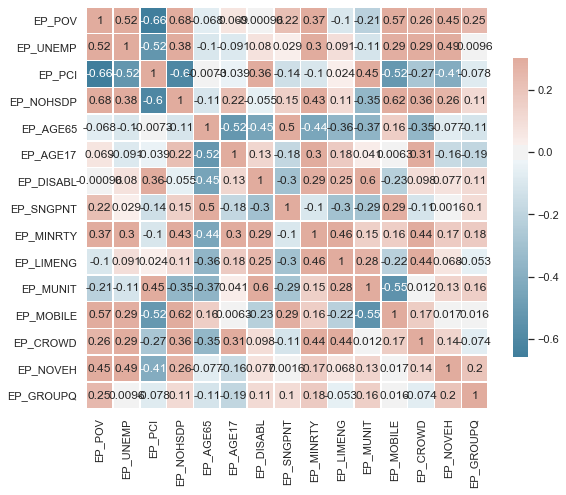

In [558]:
#plt.subplots(figsize=(10, 10))
import seaborn as sns
sns.set(style = "white")
sns.set(style = "whitegrid", color_codes = True)
from scipy import stats
def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            _ , p = stats.spearmanr(df[col],df[col2])
            p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
    return p_matrix


corr = Ready.corr(method ='spearman')
p_values = corr_sig(Ready)

mask = np.invert(np.tril(p_values < 0.05))

#print (mask)
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 11))

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

ax = sns.heatmap(corr, annot=True, cmap=cmap, vmax=.3, center=0, 
                    square=True, linewidths=.5, cbar_kws={"shrink": .5})

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

#sns.heatmap(corr, mask = mask , annot=True, cmap="RdYlGn")
#plt.show()

# SVI calculation 

We calculate the ratio of county value to state value by population for each SVI variables (we use EP-estimate percentage- values in the CDC data set), then we take the average of all 15 SVI variables. 

Let SVI variable set be K, where  

K = { Below Poverty, Unemployed, Income, No High School Diploma, Aged 65 or Older, Aged 17 or Younger, Civilian with a Disability, Single-Parent Households, Minority, Speaks English “Less than Well”, Multi-Unit Structures, Mobile Homes, Crowding, No Vehicle, Group Quarters }

We will use these variables in a county base and state base. While County base values are exactly same as the estimated values for these variables in the CDC website, to calculate the state base, we simply sum the county values for all of the counties in each state for each variable. Then we use the following formula to calculate the SVI value for each county.

Let $S$ is the set of states and $j$ is a county in the state $s$, where $s \in S$, $c^k_j$ SVI variable $k \in K$ value for county j, and $c_s$ SVI variable value for state s.

$SVI_j = \frac{1}{15}\sum_{k \in K} \frac{c^k_j}{c^k_s}$


In [585]:

from collections import Counter
# Sum all SVI variable values for each county
#SVI_county_sum = dict(Counter(E_POV_Prop) + Counter(E_UNEMP_Prop) + Counter(E_PCI_Prop) + Counter(E_NOHSDP_Prop) + Counter(E_AGE65_Prop) + Counter(E_AGE17_Prop) + Counter(E_DISABL_Prop) + Counter(E_SNGPNT_Prop) + Counter(E_MINRTY_Prop) + Counter(E_LIMENG_Prop) + Counter(E_MUNIT_Prop) + Counter(E_MOBILE_Prop) + Counter(E_CROWD_Prop) + Counter(E_NOVEH_Prop) + Counter(E_GROUPQ_Prop))
SVI_county_sum = dict(Counter(E_POV) + Counter(E_UNEMP) + Counter(E_PCI) + Counter(E_NOHSDP) + Counter(E_AGE65) + Counter(E_AGE17) + Counter(E_DISABL) + Counter(E_SNGPNT) + Counter(E_MINRTY) + Counter(E_LIMENG) + Counter(E_MUNIT) + Counter(E_MOBILE) + Counter(E_CROWD) + Counter(E_NOVEH) + Counter(E_GROUPQ))

# Divide the sum of all SVI variable values
SVI_county = {j: (SVI_county_sum[j]/(15*100)) for j in SVI_county_sum }


In [586]:
for i in SVI_county:
    print (i, E_POV[i], E_UNEMP[i], E_PCI[i], E_NOHSDP[i], E_AGE65[i], E_AGE17[i], E_DISABL[i], E_SNGPNT[i], E_MINRTY[i], E_LIMENG[i] , E_MUNIT[i], E_MOBILE[i] , E_CROWD[i], E_NOVEH[i] , E_GROUPQ[i])


1001 15.2 3.7 1.8506255535150962 11.5 15.0 23.8443 1.1371597895862495 4.4259 25.3973 0.8033 3.55 18.8 1.1357 4.4 1.0202
1003 10.4 4.3 2.0248334722486847 9.2 20.0 21.7239 4.383897740668283 5.1897 16.9276 0.7085 17.3137 11.1 1.2875 3.3 1.4133
1005 30.7 9.2 1.1464705674262843 26.8 18.6 20.9258 0.46850099484805247 4.7512 54.1895 1.8907 1.7315 29.3 3.8523 10.2 11.3797
1007 18.1 7.3 1.2895233827739585 20.9 15.9 20.5886 0.43008287099911097 5.1662 25.4746 0.3353 2.613 31.5 1.1174 6.2 8.416
1009 13.6 3.4 1.535847297791277 19.5 17.9 23.2121 1.1927128552712356 5.3581 13.1066 1.6185 0.8099 25.3 1.794 4.1 0.9553
1011 28.9 3.9 1.295667516708631 25.3 16.0 20.765 0.20564014746055786 11.9852 78.6202 0.6491 0.768 37.4 0.0 10.7 4.2642
1013 22.5 6.8 1.3056594920973406 15.0 19.7 22.4682 0.40727797274043376 3.4891 48.3962 0.1606 1.1597 26.0 1.537 7.5 1.629
1015 17.9 8.1 1.5729603492350555 15.6 17.2 21.7697 2.3524899342639425 3.948 27.9276 0.8842 3.3152 15.2 1.6792 6.0 2.7343
1017 17.3 3.9 1.410606264658259 

5129 21.9 3.8 1.1687045988898164 18.2 25.3 20.1315 0.2656155673878544 6.5825 6.8665 0.2525 1.2358 20.1 0.9618 9.0 1.0749
5131 18.5 4.8 1.4865624738744991 15.9 15.6 24.1475 4.295278405722602 5.5634 30.4387 3.5467 9.0762 3.7 3.3048 6.8 1.4836
5133 21.3 5.5 1.2780738190700982 23.5 13.9 28.6342 0.5759134927818977 6.2362 42.72 8.2962 0.5158 22.2 7.9354 4.4 0.6967
5135 22.2 4.3 1.2267103685456413 16.5 25.9 21.1273 0.5760832585797937 8.1509 6.564 0.1473 1.1637 14.4 3.0079 5.6 1.2194
5137 19.8 6.3 1.1850240898591256 18.8 26.7 19.519000000000002 0.4196950055581322 6.7057 5.3467 0.0504 0.9973 31.3 1.9428 5.1 1.1222
5139 19.1 5.0 1.442585740315098 15.1 17.2 24.1502 1.3271271484710552 6.0219 39.4788 0.6844 1.3978 21.0 4.0697 5.1 1.2218
5141 18.5 7.4 1.2693700905531335 14.9 25.6 19.8293 0.5587671471944164 6.6784 6.5257 0.2396 6.045 25.3 3.2585 6.8 1.1477
5143 16.4 4.8 1.5912935229371878 15.0 11.4 24.5496 7.8218233254131935 4.5577 29.1064 3.8094 15.73 4.9 3.8614 6.0 3.4052
5145 15.7 5.7 1.3572090349

12027 26.8 4.8 1.0019277212818263 26.5 21.7 19.535 0.17059094155397556 5.5666 45.2429 9.4801 1.4023 31.0 5.2932 6.9 9.4328
12029 21.2 4.7 1.1449364826667534 21.6 22.7 18.0963 0.07290987482679594 6.3346 15.9202 0.6686 1.1002 50.2 5.6888 9.8 9.5425
12031 14.5 5.8 1.6963405785329824 10.2 13.7 22.6506 4.445899522605704 4.4106 47.1227 2.6993 18.2689 4.7 2.3936 7.8 2.2369
12033 14.0 6.2 1.5173765662735417 9.5 16.6 20.9298 1.4471476021097673 4.6618 35.6629 1.1176 11.2327 7.0 1.4071 6.0 5.6955
12035 12.4 4.8 1.5910740006714534 7.8 30.0 17.151 0.531108925633579 7.1437 25.3386 2.5932 7.3633 4.8 1.2749 3.3 0.4809
12037 18.8 6.2 1.4389681276194808 19.3 22.7 16.0698 0.049668668308494784 8.4833 22.8939 0.8235 2.2464 18.5 2.8578 5.0 13.7414
12039 22.8 7.1 1.122735198241225 20.2 17.3 21.8587 0.2084811509686605 5.942 67.6809 2.7451 1.1186 29.3 3.3121 10.1 8.2729
12041 17.2 4.9 1.168437354473288 14.6 20.3 20.8155 0.08066665785913177 6.4975 13.7804 1.3712 0.3576 49.7 2.4443 6.2 7.5642
12043 17.4 12.0 1.1

13275 19.2 7.4 0.7052099588366373 15.1 17.6 23.8606 0.4308250353766461 4.2512 42.3885 1.0977 2.5247 16.4 2.5121 6.6 1.7409999999999999
13277 23.3 2.7 0.59013235209124 18.1 14.5 24.8563 0.3921904970588894 3.9422 44.1454 1.2488 2.8785 23.1 1.4197 9.8 5.0911
13279 23.3 9.0 0.6267362783439613 19.9 16.2 26.5646 0.26163003875496527 4.1376 39.7635 1.8511 2.0871 22.4 3.9482 8.6 1.5572
13281 15.4 4.3 0.6671418755338072 10.1 34.4 12.387 0.11200687236572124 5.0429 5.9137 0.0267 3.3054 13.6 0.9392 3.2 7.1361
13283 27.5 8.8 0.5607464632258976 26.3 20.7 21.56 0.0631898911056263 8.1526 27.947 2.2863 0.2496 36.3 1.8072 8.7 7.1229
13285 21.3 6.5 0.5939853969599477 16.6 14.5 24.6857 0.6704649137003693 4.6253 43.7249 1.2195 8.9628 7.6 2.3508 10.1 2.214
13287 33.6 6.2 0.5015893810083418 18.8 19.5 24.3485 0.07489970048931534 5.8694 46.2546 1.2412 0.9904 18.2 1.3253 14.7 4.6834
13289 19.3 6.1 0.5388868553374304 25.8 21.9 19.407 0.07995175871839857 6.2089 44.9508 0.1026 0.1881 30.3 0.9855 9.8 0.6927
13291 14

17191 13.3 2.9 0.8785237942291808 12.1 21.3 22.6985 0.12988938634154532 6.2544 3.8105 0.7804 2.0411 23.6 1.9572 7.6 0.4451
17193 14.0 6.6 0.892980557156298 10.1 21.6 21.5893 0.10742976025937533 6.2903 3.7496 0.6418 1.5355 13.4 0.8939 7.8 2.8194
17195 10.7 4.5 0.9968155056628443 9.4 20.3 22.2722 0.4378753479633813 5.9955 15.4277 1.0959999999999999 4.101 3.2 1.3473 5.4 1.9084
17197 6.7 4.7 1.2194429772517994 9.0 12.6 25.2921 5.417010847729374 3.5721 36.3187 3.3073 5.8399 1.4 1.7242 3.7 1.3428
17199 13.9 5.7 0.9473687022100484 7.7 18.6 21.8801 0.5167778886728435 5.9048 10.3037 0.5303 3.1899 9.6 0.7917 7.3 3.0714
17201 15.6 8.1 0.9775175634645216 12.3 17.0 23.5553 2.2373139049625843 5.2536 30.9839 2.1264 7.7299 1.6 1.9864 8.4 1.5045
17203 7.0 3.7 1.2410112655911014 5.2 17.4 24.2894 0.30284756767729426 3.4761 4.5039 0.1485 2.104 2.8 0.9173 4.3 2.7649
18001 16.8 3.6 0.9044378198998819 15.3 15.1 31.3461 0.5319668167956659 4.2465 6.5157 1.1904 5.3424 3.3 4.0381 10.6 1.6452
18003 13.3 4.9 1.131

19159 8.7 4.6 0.9545642551603765 7.3 24.0 24.1338 0.15348217529976987 4.4647 4.6132 0.0857 1.1094 5.7 1.3699 3.3 4.4521
19161 9.9 2.6 1.0713453460511195 7.2 23.2 22.322 0.31103395373248816 6.5384 5.1214 0.9 1.1492 2.3 1.0202 3.0 1.9384
19163 12.1 3.8 1.1167897216706268 7.2 15.8 23.8608 5.515248899834471 5.182 20.0266 1.2464 11.3091 2.2 1.1862 6.6 1.9432
19165 8.0 2.1 1.08558613285957 7.6 22.7 22.2902 0.36813759134401874 5.9245 5.4455 0.4265 2.6703 0.9 0.8549 5.0 1.8353
19167 6.3 2.7 0.9746142207368429 9.8 15.2 27.0824 1.1111954459203035 3.5108 13.099 2.383 3.7593 3.5 2.0493 4.1 6.3945
19169 20.9 4.5 0.9805561807338421 2.8 11.8 16.6122 3.109822762323873 3.1234 16.1614 1.185 24.4082 3.8 0.8384 6.1 11.0799
19171 12.0 3.4 0.9488878576213438 8.7 19.5 24.0488 0.5383503573014655 5.5564 19.252 2.7091 2.3095 4.3 2.5861 3.7 2.1665
19173 10.0 3.6 0.9884898591655894 9.8 22.0 23.269000000000002 0.1961161128830393 7.7599 9.6157 3.073 1.868 5.6 0.5352 4.6 1.5405
19175 14.2 4.4 0.9211697760710964 9.7 

21067 16.8 5.1 1.1900780070875325 8.8 13.0 20.9142 7.233488529741143 4.1769 28.9993 2.3655 17.5979 1.0 1.9918 7.9 3.8868
21069 19.9 7.4 0.815211382068874 20.4 17.5 24.4815 0.3323707033763807 6.1804 4.21 0.4978 0.7606 32.8 2.842 7.1 0.2343
21071 30.7 11.3 0.6727834874862478 24.8 17.5 21.5986 0.8239761273877766 4.44 2.968 0.1954 2.3021 30.0 2.1267 9.0 2.3508
21073 12.4 3.9 1.0611603761589112 11.0 17.0 20.9187 1.1382774801844036 4.5834 18.4251 1.6544 8.3692 5.1 1.8030000000000002 6.8 3.6969
21075 28.2 10.2 0.6304904882215379 20.9 20.1 21.8923 0.13008100290621114 7.0873 29.1843 0.1569 2.1869 6.3 0.2048 17.6 7.031000000000001
21077 14.8 5.6 0.8167662717477236 18.8 13.7 24.6538 0.19777808822148582 7.0209 8.9504 0.4898 3.75 30.4 1.5137 5.8 1.4193
21079 15.7 6.5 0.9077791476163886 19.0 17.9 22.3904 0.3971592873942806 2.9228 5.8126 0.5591 0.1735 11.3 2.4307 4.1 0.7853
21081 16.4 3.6 0.8196341793776019 13.4 13.6 26.7444 0.5617758805086901 4.8791 5.5709 0.1553 1.146 26.8 2.5380000000000003 4.5 1.

24027 5.0 3.8 5.976478310814507 4.5 13.4 24.4459 5.322796206377573 3.6122 47.982 3.3016 18.2595 1.0 2.0540000000000003 3.8 0.7797
24029 11.5 4.2 4.027460204583995 11.4 26.2 15.776 0.32362295569552585 7.1277 22.2615 1.4555 5.5961 2.8 0.2368 10.4 8.5023
24031 6.8 4.5 5.963568732563864 9.0 15.0 23.3421 17.473241274501213 3.6849 56.1809 6.5429 27.338 0.1 3.1783 7.7 0.8394
24033 8.5 6.0 4.068814616268257 13.3 12.9 22.3444 15.23250572264224 4.2879 87.2962 6.8857 22.7558 0.4 3.9635 8.9 2.0457
24035 5.7 2.6 4.896231059570046 6.8 18.4 21.6937 0.8299583551421189 4.4194 13.4732 0.8744 3.0825 2.8 1.1035 3.4 0.9671
24037 8.1 3.3 4.414856955308791 10.2 12.5 24.3521 1.8488445523806918 4.0762 25.9088 0.6867 8.2578 4.5 1.2848 5.2 2.6075
24039 21.7 8.2 2.0537169739073358 18.7 16.2 17.3151 0.36500264576671415 6.5547 48.4628 0.7964 10.3436 10.1 1.6212 11.6 23.5104
24041 8.7 3.4 5.375635906132049 8.8 28.5 18.4492 0.6205095647042391 4.7605 22.1729 1.4336 3.2597 1.8 0.8202 4.8 1.1381
24043 12.2 5.5 3.3328592

28015 17.0 7.2 1.254628843404273 19.8 22.9 19.2453 0.33744890955628704 3.6060000000000003 35.6405 0.0312 0.0579 26.4 2.6914 4.6 2.2244
28017 20.6 3.7 1.1168074305862652 24.6 16.8 24.9753 0.5740368324302012 4.9876 50.4159 1.1165 0.2765 22.0 2.0692 7.4 2.7104
28019 19.9 8.5 1.2474547316349744 19.5 21.4 21.9282 0.2792361442990916 7.0632 32.6205 0.0 1.3349 23.6 2.1995 6.2 1.921
28021 41.0 12.6 0.8026037541902697 19.7 16.0 21.7406 0.30971385237544424 6.3274 88.7226 0.39799999999999996 3.5747 35.7 2.7510000000000003 8.6 8.3948
28023 19.1 6.9 1.344473383765097 17.1 20.0 22.3906 0.5385537864695432 6.237 36.7533 0.0 0.0 26.1 1.6194 6.8 0.3551
28025 25.5 10.3 1.1545275651232798 18.3 17.9 23.055 0.6645443119820247 5.9464 61.1914 0.0 1.1196 19.7 0.3676 9.3 1.3951
28027 34.8 14.8 1.0640664995322815 20.5 14.6 27.3275 0.7863865780150475 3.8032 79.2131 0.1452 4.0986 8.2 2.1294 13.8 3.195
28029 24.0 7.5 1.1261674045352716 19.8 16.8 23.2027 0.9719954773686734 6.0336 56.1103 0.9456 0.1216 28.7 2.56 6.6 3

29219 13.4 4.5 0.9972631930806836 11.3 17.6 23.8383 0.5720092871592787 3.2085 8.3331 0.2761 1.0321 14.8 5.2236 3.3 1.0043
29221 20.1 7.3 0.7166186158581596 23.1 16.2 22.8117 0.3965855383993388 6.7057 5.7643 0.0897 0.0994 33.0 3.5424 6.4 4.457
29223 24.1 6.5 0.6774815805234057 23.8 23.1 21.4551 0.2183574134102934 7.2245 5.1610000000000005 0.1357 0.727 27.5 3.4279 8.0 1.0004
29225 17.8 4.5 0.7994888508196493 13.9 15.5 27.0004 0.6302000939132182 3.6317 5.9449 1.0561 2.5507 11.2 4.0147 7.1 2.3309
29227 13.7 3.7 0.9100753492388474 10.2 24.7 20.2269 0.033101655132834785 3.9581 3.6014 0.0 3.2132 8.9 0.5821 5.5 2.0227
29229 24.2 7.5 0.6911656151199878 19.6 19.4 25.4573 0.3007526578559175 7.5605 4.9992 0.8516 1.5891 15.5 3.0723 9.1 1.0163
29510 21.8 7.0 1.0634549227705121 12.2 13.1 19.4108 5.067958549316208 5.4857 56.3587 2.0263 18.5414 0.3 1.771 19.7 3.3277
30001 17.7 3.8 1.7529447199954573 4.9 21.3 17.5677 0.8953857651719753 7.3146 9.6973 1.1157 2.3952 15.3 0.9269 5.0 5.6612
30003 25.5 12.0 1

34021 11.6 6.1 4.883433886175618 11.5 14.9 21.3915 4.133465800576773 4.5646 50.2933 6.6847 16.85 0.3 2.0187 11.2 4.6192
34023 8.5 5.2 4.488211912423254 10.2 14.7 21.8518 9.320363031974154 3.5996 56.9386 6.6056 17.1909 0.7 4.2557 8.0 3.5887
34025 6.9 4.9 5.859757970460926 6.6 17.1 21.416999999999998 7.0409105637535845 4.1175 24.7575 2.5484 13.2641 1.1 1.3843 6.9 0.998
34027 4.8 4.3 6.586163944013809 5.5 16.7 21.3923 5.5778594762954565 3.698 28.6149 3.5928 14.6365 0.2 1.5653 4.7 1.8321
34029 10.1 5.1 4.091629840109079 8.0 22.4 23.8926 6.738790423014926 5.6168 15.3323 1.511 5.5821 2.2 2.3833 6.3 1.1083
34031 15.7 4.5 3.634183357153949 16.3 14.3 23.9222 5.701964886454776 4.1988 58.6994 13.2584 15.2894 0.2 6.731 16.6 1.734
34033 12.4 6.0 3.8589396444929043 11.2 18.3 21.6622 0.7044911022837607 5.4402 25.7469 2.1176 7.5702 4.0 1.4457 7.7 2.4321
34035 5.1 4.6 6.327631875723261 5.5 15.3 22.22 3.725464563283787 3.0196 43.7066 3.378 12.3417 0.2 1.5238 4.9 1.3516
34037 4.9 5.1 5.069540706049832 5.

37169 13.8 6.0 0.9864141430445021 16.2 20.3 19.2525 0.45033676601841566 5.5879 8.912 0.1438 0.7327 23.8 1.8439 3.2 1.1599
37171 16.4 4.0 0.9571734330695538 20.5 20.1 21.3892 0.707318476908474 5.7387 16.1343 1.9593 2.3273 24.0 2.5864 6.6 1.3797
37173 17.5 6.9 0.8685504340312317 20.2 19.0 23.0435 0.139946834317918 5.4982 38.2959 0.3447 0.4434 24.6 3.5231 7.2 2.0547
37175 14.3 5.9 1.1091575597557743 11.0 29.9 16.0059 0.3308566219384828 5.1349 9.6136 0.9001 1.4355 15.0 2.2997 3.8 3.8845
37177 22.5 5.2 0.741077454474204 26.0 20.0 13.9194 0.03335901526890637 5.1443 46.8864 0.6556 0.0 32.1 2.1957 7.4 18.2173
37179 8.2 4.6 1.3648917793441222 10.4 12.3 27.2526 2.2856491921820226 3.0021 27.862 2.6729 1.6199 5.8 2.5136 2.5 0.995
37181 20.8 8.4 0.8651721748556921 19.6 17.9 23.8629 0.4378818059075874 4.7111 60.3858 1.4766 1.9812 23.1 3.1881 10.3 1.6615
37183 9.1 4.0 1.5383090836884885 7.0 11.3 24.1774 10.54647852155548 3.2369 39.9742 2.4953 17.5715 3.0 2.0411 4.0 2.0534
37185 19.8 8.8 0.87954854445

40133 20.4 7.8 1.062787026037408 15.7 17.7 25.0362 0.6336948029236427 7.5775 35.571 0.4396 1.4406 16.3 3.1985 6.9 2.6337
40135 21.5 7.2 1.048284657831536 18.7 18.1 23.7023 1.071555711004011 6.2944 37.5411 0.4583 1.3531 21.4 4.4785 5.4 0.9494
40137 14.3 6.6 1.3252181783585582 12.7 19.2 23.2937 1.1180084871740743 5.7656 19.8525 0.7694 3.1096 8.0 1.3816 6.1 1.2991
40139 19.6 2.7 1.1315447079212757 27.7 11.0 28.7239 0.5371021101608502 5.4965 56.0346 14.0066 3.5228 24.5 3.6348 4.4 2.3312
40141 19.8 3.6 1.130053329630601 22.5 19.6 23.7016 0.18357804780455456 6.3057 40.8337 5.608 1.5223 4.8 2.9925 4.8 4.7754
40143 15.0 5.4 1.647921584358013 10.6 14.0 25.3158 16.65535857051124 5.0297 38.0229 3.3682 15.3052 2.5 2.8133 6.7 1.2461
40145 10.4 5.9 1.5127204282827036 9.4 16.0 24.5016 2.0425459652686953 5.2486 28.5126 1.0365 2.62 14.5 3.1738 3.1 0.3002
40147 13.3 5.2 1.5863636597394717 9.6 19.3 23.7945 1.3365364716610801 5.407 27.2097 0.831 5.396 6.0 1.496 5.3 1.5303
40149 14.6 5.1 1.3507258898128578

46079 12.7 3.4 1.7674388381688815 9.1 21.0 20.563000000000002 1.470719221429442 6.4894 6.7783 1.1282 7.3466 6.1 1.3404 3.1 5.6145
46081 12.7 2.6 1.6617949607451246 6.5 21.1 17.6819 2.9536270474511754 4.6253 9.1451 0.4792 11.494000000000002 12.7 1.05 7.3 5.5303
46083 4.1 2.0 2.099200439344379 5.2 12.2 28.2318 6.620756256035704 3.9344 7.0214 0.5912 11.9521 1.8 0.9064 1.4 0.9696
46085 20.5 7.0 1.1974020829031944 10.3 15.6 29.4179 0.4485172093720994 5.2971 44.4387 0.2287 1.963 11.5 5.0107 6.9 1.9751
46087 9.7 3.1 1.5207268466455448 11.3 18.7 27.3792 0.6325182594672643 4.8474 6.615 0.7034 2.099 3.6 1.1221 2.6 4.8666
46089 13.8 2.4 1.4965691941195767 17.6 29.5 21.4192 0.2573670738910714 4.7573 4.963 0.1409 2.2965 5.1 0.0 3.6 6.3561
46091 8.5 2.6 1.7016210256469377 7.9 20.8 26.4568 0.5657153304518222 6.7272 17.0108 1.1525 1.479 9.5 1.8153 2.1 1.5130000000000001
46093 6.9 1.6 1.5096698733635943 5.6 15.1 23.2096 3.1070393879445324 5.7314 12.4292 0.1493 4.7161 15.4 1.5145 2.0 2.9404
46095 52.8 6

48081 12.5 2.9 0.37878742482676303 16.3 28.5 20.9204 0.01153529651414925 7.3601 23.7965 2.2118 0.37 26.7 1.399 3.2 3.1487
48083 13.8 3.4 0.41574485322492893 13.5 24.7 21.4183 0.029860082897980235 8.4137 23.1701 2.8081 1.3156 14.7 0.9641 4.7 0.6839
48085 6.3 3.7 0.6673609729556116 6.2 10.7 26.2961 3.494072257226894 2.9942 43.0388 4.0679 19.4687 1.5 2.4346 2.8 0.4098
48087 17.0 8.9 0.3847197886880008 26.1 17.0 25.0589 0.010448690292292395 3.5749 39.9124 4.3494 1.276 7.6 3.8647 6.0 2.1893
48089 10.0 3.5 0.4427101435032826 16.9 21.6 23.5158 0.0752312897112747 4.8993 44.068000000000005 4.0839 2.4556 18.6 7.2752 5.4 1.5548
48091 7.6 3.4 0.5841131295796052 7.4 17.9 22.726999999999997 0.5052503049603538 4.3569 32.4904 1.9789 9.9105 10.0 2.2524 3.3 0.7597
48093 11.2 3.5 0.4004045991999099 15.5 24.0 22.315 0.047950997081742684 5.3946 30.5418 3.0096 1.6928 19.5 3.9366 4.6 1.53
48095 12.2 1.3 0.3208869543124091 32.1 20.0 15.1868 0.007897684294621836 7.1272 47.1525 19.3884 0.1802 15.1 1.2061 6.7 32

48477 12.0 5.6 0.48874588629516086 13.3 21.0 21.9009 0.12402062867941686 6.1941 35.9895 3.6156 4.159 13.3 3.0178 5.2 6.8026
48479 27.5 4.9 0.27663391682226635 32.4 9.2 33.2374 0.9762401316275919 3.3895 96.4694 21.0228 11.2438 9.7 11.5552 6.1 1.1725
48481 17.6 5.2 0.37898217414543994 21.7 16.6 25.9807 0.1483397394526966 6.4873 55.5427 5.4722 4.8205 13.0 5.0661 6.7 1.3685
48483 18.3 4.6 0.4058725608396872 19.8 19.2 25.6463 0.018968834442481236 5.0847 31.5287 5.3837 0.7718 9.1 5.7261 4.3 1.1802
48485 16.9 4.9 0.3726003887795629 13.4 14.5 22.3639 0.42118584215418314 4.5558 34.7252 1.7015 8.1221 4.8 2.1549 6.8 11.3005
48487 19.2 5.6 0.3549830657977052 22.8 18.5 22.410999999999998 0.04545396159178025 6.5058 41.8686 3.0745 3.4455 7.1 3.6293 5.4 5.4235
48489 27.0 13.8 0.22303291203562775 34.3 13.7 24.0597 0.07316601828297724 4.6005 88.7576 9.4455 1.625 10.4 11.7088 5.1 5.8412
48491 6.4 4.8 0.5579118558591382 6.8 11.8 25.9901 1.9584781856784794 3.6279 40.6213 2.9135 14.7635 2.1 2.3107 2.3 0.788

51735 5.6 2.0 0.9686079406699365 5.1 19.6 22.0678 0.14308401552865974 3.2005 8.5608 0.2861 1.7080000000000002 0.2 0.0 4.2 0.4715
51740 16.8 7.8 0.6330670210866752 11.7 14.5 23.4256 1.0883226222726508 5.2048 62.3353 0.5989 8.6807 0.9 1.3638 11.2 3.9213
51750 36.3 4.5 0.5244360694217947 8.8 8.7 10.5703 0.21388522165088739 5.0242 16.7091 0.1459 24.8849 3.4 1.1843 8.6 16.7147
51760 23.2 6.5 0.8071893238992425 14.6 12.8 17.6311 2.719737858230725 5.0453 59.2034 3.2147 22.7667 0.5 1.7298 16.5 4.8217
51770 20.8 6.3 0.6497646690280766 13.8 16.1 21.8696 1.1905653931719706 5.1821 41.4969 1.8205 14.9819 0.7 1.8471 13.1 1.9369
51775 9.1 4.4 0.7680918053044626 10.8 19.0 19.1334 0.2964542440222469 6.4568 14.7095 1.1165 16.2546 2.9 1.1602 7.0 10.1236
51790 11.1 3.7 0.7257943051877715 10.3 21.0 18.9506 0.2893984119884537 6.0961 18.9383 1.0225 13.0497 0.8 1.7175 7.6 5.546
51800 10.4 6.2 0.840656799816374 10.1 14.2 24.3115 1.0664993345536726 4.0682 50.7009 0.5337 7.0929 3.0 1.5485 5.8 0.4995
51810 7.3 4.

72017 0.0 19.8 1.1406297963036969 0.0 18.9 0.0 0 0.0 0.0 65.1184 0.478 0.0 2.178 10.5 0.0
72019 0.0 18.1 0.9888856068898811 0.0 15.1 0.0 0 0.0 0.0 77.7649 1.3671 0.7 4.5757 14.0 0.0
72021 0.0 12.7 1.712276799935132 0.0 21.0 0.0 0 0.0 0.0 52.872 8.2724 0.4 2.0748 13.2 0.0
72023 0.0 14.8 1.1471165708129898 0.0 22.5 0.0 0 0.0 0.0 59.2636 5.8185 4.4 3.9682 13.6 0.0
72025 0.0 13.2 1.7657926896367984 0.0 19.6 0.0 0 0.0 0.0 59.9854 5.4969 0.1 2.4572 15.9 0.0
72027 0.0 12.6 1.2404797896431694 0.0 19.2 0.0 0 0.0 0.0 67.1906 0.8128 0.3 1.5534 11.6 0.0
72029 0.0 23.5 1.4970548885375219 0.0 16.4 0.0 0 0.0 0.0 61.9039 1.8368 0.1 5.6068 12.7 0.0
72031 0.0 14.8 1.951360774706213 0.0 21.7 0.0 0 0.0 0.0 49.1414 21.7221 0.3 2.3098 13.0 0.0
72033 0.0 21.0 1.482227975373424 0.0 19.0 0.0 0 0.0 0.0 66.6609 11.3537 0.2 3.4229 26.2 0.0
72035 0.0 9.3 1.4848921863325977 0.0 19.9 0.0 0 0.0 0.0 62.3008 2.8336 0.4 1.8935 16.5 0.0
72037 0.0 12.7 1.2978182428949547 0.0 22.8 0.0 0 0.0 0.0 61.089 3.5521 0.5 3.5511 18.

In [587]:
SVI_county

{1001: 0.08784299022873421,
 1003: 0.08618195414194463,
 1005: 0.1500904477081829,
 1007: 0.11022047083584871,
 1009: 0.08892204010204167,
 1011: 0.1605020051094461,
 1013: 0.1187018249765585,
 1015: 0.097455766855666,
 1017: 0.1111949722915501,
 1019: 0.08752517403795929,
 1021: 0.1034282739794935,
 1023: 0.12696014418463078,
 1025: 0.12649486013697564,
 1027: 0.09726034847365665,
 1029: 0.09102394405404411,
 1031: 0.09219384716587248,
 1033: 0.08157436399845604,
 1035: 0.12021981537125372,
 1037: 0.10665253636281861,
 1039: 0.09567185601475245,
 1041: 0.10355150334545798,
 1043: 0.08550370493088205,
 1045: 0.09865933728215494,
 1047: 0.14604067235654303,
 1049: 0.10469739338217626,
 1051: 0.08760569146145934,
 1053: 0.11506488009252634,
 1055: 0.08972129724981122,
 1057: 0.09375433243608627,
 1059: 0.10267119621006014,
 1061: 0.09980792614353522,
 1063: 0.1814404673607589,
 1065: 0.14315768200217743,
 1067: 0.10432156817029499,
 1069: 0.09879728479634774,
 1071: 0.08658473762935197,


In [588]:
# Sum all SVI variable values for each county
#

#SVI_county_sum_no_race = dict(Counter(E_POV_Prop) + Counter(E_UNEMP_Prop) + Counter(E_PCI_Prop) + Counter(E_NOHSDP_Prop) + Counter(E_AGE65_Prop) + Counter(E_AGE17_Prop) + Counter(E_DISABL_Prop) + Counter(E_SNGPNT_Prop) + Counter(E_LIMENG_Prop) + Counter(E_MUNIT_Prop) + Counter(E_MOBILE_Prop) + Counter(E_CROWD_Prop) + Counter(E_NOVEH_Prop) + Counter(E_GROUPQ_Prop))


SVI_county_sum_no_race = dict(Counter(E_POV) + Counter(E_UNEMP) + Counter(E_PCI) + Counter(E_NOHSDP) + Counter(E_AGE65) + Counter(E_AGE17) + Counter(E_DISABL) + Counter(E_SNGPNT) + Counter(E_LIMENG) + Counter(E_MUNIT) + Counter(E_MOBILE) + Counter(E_CROWD) + Counter(E_NOVEH) + Counter(E_GROUPQ))


# Divide the sum of all SVI variable values
SVI_county_no_race = {j: (SVI_county_sum_no_race[j]/(14*100)) for j in SVI_county_sum }


# Proportional Allocation

We consider allocating 1 million CHW over the states proportional to Medicaid enrollment in each state. Further, we allocate CHW to counties in each state proportional to different county vulnerability criterias as follow.

- MEDICAID
- SVI
- YPLL
- UNEMPLOYMENT
- LAST 14 DAYS COVID CASES
- LAST 14 DAYS COVID CASES / POP
- COVID DEATHS / POP

To calculate the total number of allocated CHW to per county according to these vulnerability criterias, we define the following function called "Proportional_allocation", in which we multiply the CHW allocated to each state with the ratio of the chosen vulnerability criteria of the county to the chosen vulnerability criteria of the state, the function return a dictionary with the counties as keys and the number of CHW allocated to each county for the chosen vulnerability criteria as values. 

In [589]:
def Proportional_allocation(county_level, state_level, state_budget):
    prop_allocate = {}
       
    for (j,s) in cartesian_pro_county_state:
        if state_level[s] >= 1e-6 and j in county_level:
            #print (j,s, county_level[j],state_level[s], state_budget[s])
            prop_allocate[j,s] = (float(county_level[j])/float(state_level[s]))*float(state_budget[s])
        
        else:
            prop_allocate[j,s] = 0
            
    
    return prop_allocate

In [590]:
def total_state_pop(dict_1):
    state_dict = {}
    for s in State:
        state_dict [s] = sum(float(dict_1[j]*Firstphase_county[j]) for j in dict_1 if (j,s) in cartesian_pro_county_state)  
    return state_dict



In [594]:
def Proportional_allocation_pop(county_level, state_budget):
    prop_allocate = {}
    state_level = total_state_pop(county_level)
       
    for (j,s) in cartesian_pro_county_state:
        if state_level[s] >= 1e-6 and j in county_level:
            #print (j,s, county_level[j], Firstphase_county[j], state_level[s], (county_level[j]/state_level[s]), state_budget[s], ((float(county_level[j])*Firstphase_county[j])/(float(state_level[s])))*float(state_budget[s]) )
        
            prop_allocate[j,s] = ((float(county_level[j])*Firstphase_county[j])/(float(state_level[s])))*float(state_budget[s])
        
        else:
            prop_allocate[j,s] = 0
            
    
    return prop_allocate

In [595]:
# Proportional allocation according to SVI score in each county
Proportional_to_SVI = Proportional_allocation_pop(SVI_county, Vaccine_budget_state)

In [596]:
# Proportional allocation according to YPLL in each county
Proportional_to_SVI_no_race = Proportional_allocation_pop(SVI_county_no_race, Vaccine_budget_state)

In [597]:
#print ('Med', Medicaid_demand[35039])
#print ('Med', Medicaid_demand[4017], 'Pop', population_county[4017], 'Med_capita', 100000*(Medicaid_demand[4017]/population_county[4017]))

In [598]:
# Dictionaries for the different vulnerability criteria values for states

# Dictionary for total Medicaid patient numbers for each state
# Medicaid_demand_state = total_state(Medicaid_demand) 

# Dictionary for total positive COVID cases for last 14 days in each state
#Covid_state = total_state(COVID_14days) 

# Dictionary for total SVI values for each state
SVI_State = total_state(SVI_county) 


# Dictionary for total SVI values for each state
SVI_State_no_race = total_state(SVI_county_no_race) 

# Dictionary for total YPLL values for each state
#YPLL_state = total_state(YPLL) 

 

In [599]:
for j in location:
    print (j , SVI_county[j], SVI_county_no_race[j], E_MINRTY[j])

1001 0.08784299022873421 0.0759765609593581 25.3973
1003 0.08618195414194463 0.08024666515208355 16.9276
1005 0.1500904477081829 0.1221044082587674 54.1895
1007 0.11022047083584871 0.09989721875269506 25.4746
1009 0.08892204010204167 0.0859117572521875 13.1066
1011 0.1605020051094461 0.11580914833154941 78.6202
1013 0.1187018249765585 0.09261181247488413 48.3962
1015 0.097455766855666 0.08446860734535644 27.9276
1017 0.1111949722915501 0.08738504174094651 44.4534
1019 0.08752517403795929 0.08786482932638494 8.277000000000001
1021 0.1034282739794935 0.09662436497802875 19.8683
1023 0.12696014418463078 0.1048709401978187 43.6209
1025 0.12649486013697564 0.10175792157533102 47.2812
1027 0.09726034847365665 0.09017565907891784 19.6446
1029 0.09102394405404411 0.09230594005790442 7.3076
1031 0.09219384716587248 0.07745505053486336 29.8537
1033 0.08157436399845604 0.07182846142691719 21.8017
1035 0.12021981537125372 0.0931272307549147 49.9516
1037 0.10665253636281861 0.08912414610301995 35.2

19041 0.06536488869164363 0.0651958093124753 6.7732
19043 0.06760429174120766 0.06952331257986534 4.0738
19045 0.0719429617521842 0.07075338759162593 8.8597
19047 0.1095450166348996 0.09295630353739244 34.1787
19049 0.0662247780436184 0.06054333361816258 14.5765
19051 0.07604359468493388 0.07920106573385773 3.1839
19053 0.08202722504416257 0.08265831254731705 7.3192
19055 0.05848663654344227 0.06021582486797386 3.4278
19057 0.07858287741655014 0.07514815437487514 12.6669
19059 0.061427328227463676 0.06274135167228251 4.3031
19061 0.07008990551272325 0.06848832733506062 9.2512
19063 0.07339303694690204 0.06940218244310933 12.9265
19065 0.06396290917652986 0.06399775983199628 6.3475
19067 0.06934386123647855 0.06824735132479845 8.4695
19069 0.06768697160005258 0.0630677552857706 13.2356
19071 0.06052794666966716 0.061067085717500524 5.297999999999999
19073 0.0614324129111306 0.061965728119068496 5.3966
19075 0.051129113273600695 0.05259169279314361 3.0653
19077 0.059357065339326144 0.060

28027 0.1523083020516982 0.10660668076967666 79.2131
28029 0.13179757525460264 0.10113290205850282 56.1103
28031 0.11401817268235243 0.09390404215966332 39.5616
28033 0.08440274875832804 0.06492037366963718 35.7156
28035 0.11439710415811874 0.09178789731227005 43.0926
28037 0.1092349938768261 0.09072170772517082 36.8421
28039 0.09408469334782898 0.09160060001553105 12.8862
28041 0.12391820238444698 0.11296107398333606 27.7318
28043 0.11242019793280894 0.08806892635658102 45.3338
28045 0.08769662085046773 0.08302152233978684 15.3148
28047 0.10903828461005591 0.09101944779648845 36.1302
28049 0.13115186621767108 0.086588785233219 75.5035
28051 0.175655158659503 0.12779152713518185 84.5746
28053 0.16152308513977062 0.11636201979261139 79.3778
28055 0.17835276898082475 0.14611482390802652 62.9684
28057 0.08169423581542663 0.08039946694509996 9.9821
28059 0.09430206909457739 0.07790200260133294 32.3903
28061 0.12502257020412064 0.09445825379012925 55.2923
28063 0.17488723678821635 0.1252239

39137 0.05810877717856491 0.05655326126274812 7.9886
39139 0.0812480610698713 0.07668049400343352 14.5194
39141 0.08176256737241293 0.08017753647044241 10.3953
39143 0.07167227868190829 0.06564344144490172 15.6076
39145 0.08875698636766342 0.0903032711082108 6.7109
39147 0.06922560070153953 0.06687914360879235 10.2076
39149 0.06266784365874672 0.06205240392008578 7.1284
39151 0.07343389854512904 0.06895260558406682 13.6172
39153 0.08280778556358839 0.07227555596098757 23.0259
39155 0.07811814178325989 0.07449522333920704 12.8839
39157 0.0721869955670842 0.07339792382187593 5.5234
39159 0.057147488646914754 0.05374988069312295 10.4714
39161 0.061661923434200794 0.061719132250929426 6.0861
39163 0.09226332035457868 0.09635848609419143 3.4931
39165 0.059127033458242065 0.05346903584811649 13.8339
39167 0.07138004507073059 0.07294654829006848 4.9449
39169 0.07388521498779292 0.07464258748692099 6.3282
39171 0.06499019216732944 0.06434734875071012 7.399
39173 0.07153128661493159 0.068273378

54019 0.08928474900568506 0.09026773107751969 7.5523
54021 0.10232755438369247 0.09641866541109907 18.5052
54023 0.0819586232649967 0.08534702492678217 3.4521
54025 0.08236792933500563 0.08270649571607745 7.7628
54027 0.08250709485064499 0.08534831591140535 4.273
54029 0.07567274795280596 0.07661715852086352 6.2451
54031 0.08402402495507034 0.0828595981661468 10.0326
54033 0.07561709519473768 0.07685617342293323 5.827000000000001
54035 0.07653698630181631 0.07981712818051748 3.0615
54037 0.07336721811501513 0.06661659083751621 16.7876
54039 0.09110998698795911 0.08884470034424188 12.2824
54041 0.08630913122774685 0.08984506917258592 3.6806
54043 0.09638593999192249 0.10167079284848839 2.2398
54045 0.10248129412126186 0.1068950294156377 4.0689
54047 0.12386085462741327 0.12463548710079993 11.3016
54049 0.0765906082179556 0.07669108023352385 7.5184
54051 0.06664926269843546 0.06903263860546657 3.3282
54053 0.08133020294472665 0.08472128886934999 3.3855
54055 0.09629102681676804 0.0962358

In [600]:
for s in State:
    print (s, SVI_State[s], SVI_State_no_race[s])

Alabama 7.340592133333336 6.1821483571428555
Alaska 3.651278133333334 2.8322558571428575
Arizona 2.0203683999999997 1.6311087857142859
Arkansas 7.5024586666666675 6.709084214285714
California 6.5554570666666665 5.107405142857144
Colorado 5.570329533333334 4.795525142857143
Connecticut 0.7542044 0.6659298571428571
Delaware 0.4130600666666666 0.36684578571428567
District of Columbia 0.2831697999999999 0.25809514285714275
Florida 7.486490000000001 6.460516928571429
Georgia 17.7881646 14.74818521428571
Hawaii 0.7120794 0.49948385714285704
Idaho 3.799670533333333 3.516639142857143
Illinois 7.840281666666667 7.434836285714288
Indiana 6.711971466666669 6.552046928571427
Iowa 6.7479533333333315 6.580373214285715
Kansas 7.989702066666672 7.374592857142859
Kentucky 10.783263866666665 10.826571857142858
Louisiana 7.393279799999998 6.158112499999997
Maine 1.2289126000000001 1.2480600714285714
Maryland 2.2153709333333333 1.8130284999999997
Massachusetts 1.2427733333333333 1.1068969285714285
Michiga

# 1 million CHW allocation to states

We allocate 1 million CHWs to states proportional to total Medicaid enrolles in each state.

Let's $FedCHW$ represents the number of CHW will be allocated within states by the federal government, which is 1 million in our project. $TotMed$ represents the total Medicaid enrollee numbers over the US, $Med_s$ is the total Medicaid enrollee numbers in state $s \in S$, and $CHW_s$ is the total number of CHW allocated to state $ s\in S$. 

$CHW_s = FedCHW*\frac{Med_s}{TotMed}$



# Proportional allocation for different vulnerability values

Let V = {Medicaid, SVI, YPLL, Unemployment, COVID, COVID_capita, COVID_death and COVID_death capita, SVI and Medicaid, YPLL and Medicaid, Unemployment and Medicaid, COVID and Medicaid, COVID_capita and Medicaid, COVID_death and Medicaid and COVID_death capita and Medicaid}. We assume $v_j$ represent the vulnerability value for county $j \in J$, while $v_s$ represent the sum of the vulnerability values for each county in the state of county j.

$Prop_{v_j} = \frac{v_j}{v_s}*CHW_s$



In [601]:
Vaccine_budget_state

{'Alabama': 166725,
 'Alaska': 62400,
 'Arizona': 237900,
 'Arkansas': 104325,
 'California': 1323075,
 'Colorado': 189150,
 'Connecticut': 126750,
 'Delaware': 34125,
 'District of Columbia': 27300,
 'Florida': 724425,
 'Georgia': 343200,
 'Hawaii': 50700,
 'Idaho': 55575,
 'Illinois': 345150,
 'Indiana': 225225,
 'Iowa': 108225,
 'Kansas': 99450,
 'Kentucky': 154050,
 'Louisiana': 159900,
 'Maine': 49725,
 'Maryland': 205725,
 'Massachusetts': 242775,
 'Michigan': 343200,
 'Minnesota': 189150,
 'Mississippi': 100425,
 'Missouri': 209625,
 'Montana': 39000,
 'Nebraska': 66300,
 'Nevada': 100425,
 'New Hampshire': 49725,
 'New Jersey': 305175,
 'New Mexico': 72150,
 'New York': 683475,
 'North Carolina': 348075,
 'North Dakota': 27300,
 'Ohio': 398775,
 'Oklahoma': 132600,
 'Oregon': 143325,
 'Pennsylvania': 449475,
 'Rhode Island': 39000,
 'South Carolina': 172575,
 'South Dakota': 32175,
 'Tennessee': 228150,
 'Texas': 906750,
 'Utah': 94575,
 'Vermont': 25350,
 'Virginia': 289575,
 

In [602]:
# Calling proportional allocation function for different vulnerability criterias



# Proportional allocation according to SVI score in each county
Proportional_to_Adult_pop = Proportional_allocation(Adult_pop_county, Adult_pop_state, Vaccine_budget_state)

# Proportional allocation according to SVI score in each county
Proportional_to_Firstphase = Proportional_allocation(Firstphase_county, Firstphase_State, Vaccine_budget_state)


# Proportional allocation according to SVI score in each county
Proportional_to_ADI = Proportional_allocation_pop(ADI_county, Vaccine_budget_state)

# Proportional allocation according to SVI score in each county
Proportional_to_PVI = Proportional_allocation_pop(PVI_county, Vaccine_budget_state)

# Proportional allocation according to SVI score in each county
Proportional_to_SVI = Proportional_allocation_pop(SVI_county, Vaccine_budget_state)

# Proportional allocation according to YPLL in each county
Proportional_to_SVI_no_race = Proportional_allocation_pop(SVI_county_no_race, Vaccine_budget_state)


In [603]:
for j in SVI_county:
    print(j, SVI_county[j], SVI_county_no_race[j])

1001 0.08784299022873421 0.0759765609593581
1003 0.08618195414194463 0.08024666515208355
1005 0.1500904477081829 0.1221044082587674
1007 0.11022047083584871 0.09989721875269506
1009 0.08892204010204167 0.0859117572521875
1011 0.1605020051094461 0.11580914833154941
1013 0.1187018249765585 0.09261181247488413
1015 0.097455766855666 0.08446860734535644
1017 0.1111949722915501 0.08738504174094651
1019 0.08752517403795929 0.08786482932638494
1021 0.1034282739794935 0.09662436497802875
1023 0.12696014418463078 0.1048709401978187
1025 0.12649486013697564 0.10175792157533102
1027 0.09726034847365665 0.09017565907891784
1029 0.09102394405404411 0.09230594005790442
1031 0.09219384716587248 0.07745505053486336
1033 0.08157436399845604 0.07182846142691719
1035 0.12021981537125372 0.0931272307549147
1037 0.10665253636281861 0.08912414610301995
1039 0.09567185601475245 0.09057006001580618
1041 0.10355150334545798 0.0902221821558478
1043 0.08550370493088205 0.08581425528308792
1045 0.0986593372821549

22071 0.13677579003086746 0.09702291789021514
22073 0.11353350081318907 0.0915306794427026
22075 0.10920803249263253 0.09123824909924914
22077 0.11653634121800417 0.09652057987643305
22079 0.11014763969762799 0.09031432824745857
22081 0.12518969787824152 0.10320031915525878
22083 0.12112329899755253 0.10161067749737772
22085 0.12275524060349427 0.10836597207517241
22087 0.1010777129242955 0.08140026384745946
22089 0.08393348151643455 0.06501473019617988
22091 0.13913844357558203 0.10918318954526646
22093 0.11024220679226544 0.08110172156314155
22095 0.11509092439500217 0.07639634756607375
22097 0.12705041869457265 0.10352773431561356
22099 0.1116048785347557 0.09409301271580967
22101 0.11752676086491427 0.09454752949812242
22103 0.08145207885588614 0.07195779877416372
22105 0.11099227386649452 0.0926540077141013
22107 0.14665237127725708 0.11587718351134685
22109 0.1108906858744966 0.09500216343696065
22111 0.10961879898681633 0.09524971320016033
22113 0.10174571376097494 0.09352362188

36065 0.08734451462389396 0.0807341942398864
36067 0.08859054548192102 0.07837994158777252
36069 0.06904388430056145 0.06671801889345869
36071 0.09382490027856716 0.07498617886989338
36073 0.08043876704037278 0.07644732182897084
36075 0.08002099839791879 0.08147842685491298
36077 0.07847827472591691 0.0777475800634824
36079 0.06527527214483594 0.054734077298038517
36081 0.1745934542430679 0.1335259866890013
36083 0.0755519388910415 0.0689557202404016
36085 0.10128631725830953 0.08067391134818881
36087 0.10622208807541136 0.08747530865222647
36089 0.08587116987665881 0.0862702534392773
36091 0.06272457756602363 0.06031533310645391
36093 0.08573133828089302 0.07228007672952823
36095 0.07432600694774956 0.07475522172973167
36097 0.07512274779982185 0.07688537264266627
36099 0.08152849043331184 0.07950288260711984
36101 0.07723175187811757 0.07815394844084024
36103 0.08333218146595772 0.06611848014209755
36105 0.0965843303425821 0.08313656822419513
36107 0.0687320737648919 0.07006907903381

54013 0.09805907796705943 0.10302665496470652
54015 0.09966458122064227 0.10624219416497387
54017 0.08114724962429269 0.08350555316888504
54019 0.08928474900568506 0.09026773107751969
54021 0.10232755438369247 0.09641866541109907
54023 0.0819586232649967 0.08534702492678217
54025 0.08236792933500563 0.08270649571607745
54027 0.08250709485064499 0.08534831591140535
54029 0.07567274795280596 0.07661715852086352
54031 0.08402402495507034 0.0828595981661468
54033 0.07561709519473768 0.07685617342293323
54035 0.07653698630181631 0.07981712818051748
54037 0.07336721811501513 0.06661659083751621
54039 0.09110998698795911 0.08884470034424188
54041 0.08630913122774685 0.08984506917258592
54043 0.09638593999192249 0.10167079284848839
54045 0.10248129412126186 0.1068950294156377
54047 0.12386085462741327 0.12463548710079993
54049 0.0765906082179556 0.07669108023352385
54051 0.06664926269843546 0.06903263860546657
54053 0.08133020294472665 0.08472128886934999
54055 0.09629102681676804 0.0962358144

# Normalize values for comparison
To be able compare the different vulnerability values for each county, we normalize all vulnerability values as follows. 

Let $m_{v_s} = \min \{v_j, \text{ for county j in state s }\}$  and 
$M_{v_s} = \max \{v_j, \text{ for county j in state s }\}$.

We calculate the normalize value for each vulnerability for each county by substracting the min vulnerability in the state of the county and dividing that by the differences between max and min value of the vulnerability values in the state. Mathematical formulation for the normalization is as follows.

$N_{v_j} = \frac{v_j - m_{v_s}}{M_{v_s} - m_{v_s}}$ 

for each $v \in V$, where V = {Medicaid, SVI, YPLL, Unemployment, COVID, COVID_capita, COVID_death and COVID_death capita, SVI and Medicaid, YPLL and Medicaid, Unemployment and Medicaid, COVID and Medicaid, COVID_capita and Medicaid, COVID_death and Medicaid and COVID_death capita and Medicaid}, j is a county in each state $s \in S$.


In [604]:
#Normalize function to normalize the vulnerability values to be able to compare them

def normalize(dict_1):
    
    result = {}
    min_data = {s: min(dict_1[j] for j in location if (j,s) in cartesian_pro_county_state) for s in State }
    max_data = {s: max(dict_1[j] for j in location if (j,s) in cartesian_pro_county_state) for s in State }
    
    for (j,s) in cartesian_pro_county_state:
        
        if (max_data[s] - min_data[s]) != 0 :
    
            result[j] = (dict_1[j] - min_data[s])/(max_data[s] - min_data[s])
        
        else:
            result[j] = 1
    
    return result 

# Percentile Rank

<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.percentileofscore.html"> The function scipy.stats.percentileofscore (a, score, kind='rank')   </a>
computes the percentile rank of a score relative to a list of scores. 
"rank": Average percentage ranking of score. In case of multiple matches, average the percentage rankings of all matching scores.

In [605]:
from scipy import stats

# Calculate percentile ranks

def percentile_ranks(data):
    x = {s: [] for s in State}

    for (j,s) in cartesian_pro_county_state:
         
        x[s].append(data[j])
    
    
    
    percentile_ranks = {i: stats.percentileofscore(x[s], data[i], 'rank') for (i,s) in cartesian_pro_county_state}

    return percentile_ranks

In [606]:
# Write timestamp 

time_stamp = time.strftime('%m-%d-%Y %H:%M:%S')
with open('Output/time_stamp.csv','w') as f:
    w = csv.writer(f)
    now = time.strftime('%m/%d/%Y %H:%M:%S')
    w.writerow(['time',now])
    

In [607]:
#print (Medicaid_demand)

In [608]:
#Write a function to order the dicts
def order_k(dict_1):
    dict_2 = {}
    for m in location:
        if m in dict_1.keys():
            dict_2[m] = dict_1[m]
        else:
            dict_2[m] = 0
    
    return dict_2
            

In [609]:
Adult_pop_county = order_k(Adult_pop_county)
ADI_county = order_k(ADI_county)#{m: SVI_county[m] for m in location}
PVI_county = order_k(PVI_county)#{m: SVI_county[m] for m in location}

SVI_county = order_k(SVI_county)#{m: SVI_county[m] for m in location}
SVI_county_no_race = order_k(SVI_county_no_race)#{m: SVI_county[m] for m in location}
Firstphase_county = order_k(Firstphase_county)



In [610]:
# Write file allocation with each strategies for each county 

Strategies = ["Adult_pop", "Firstphase", "ADI", "PVI" , "SVI", "SVI_no_race"]

fieldnames = []  
fieldnames.append('County_FIPS')


SVI_values = {i:SVI_county[i] for i in location}
s_count = 1
for s in Strategies:   
    fieldnames.append('Proportional_allocation_to_' + s)
    fieldnames.append(s)
    fieldnames.append('Percentile_ranks_' + s)

    
        

writefile = 'Output/County_level_proportional_vaccine_allocation.csv'
with open( writefile, 'w' ) as f:
    writer = csv.writer(f)                
    writer.writerow(fieldnames)
    for row in zip(location
                   , Proportional_to_Adult_pop.values(),        Adult_pop_county.values(),            percentile_ranks(Adult_pop_county).values()
                   , Proportional_to_Firstphase.values(),       Firstphase_county.values(),    percentile_ranks(Firstphase_county).values()
                   , Proportional_to_ADI.values(),              ADI_county.values(),           percentile_ranks(ADI_county).values()
                   , Proportional_to_PVI.values(),              PVI_county.values(),           percentile_ranks(PVI_county).values()
                   , Proportional_to_SVI.values(),              SVI_county.values(),           percentile_ranks(SVI_county).values()
                   , Proportional_to_SVI_no_race.values(),      SVI_county_no_race.values(),   percentile_ranks(SVI_county_no_race).values()
                    ):                    
       
        writer.writerow(row)

In [611]:
Vaccine_state = {s: Vaccine_budget_state[s] for s in State}

In [612]:
writefile = 'Output/State_level_vaccine_allocation.csv'

cl = ['State', 'Vaccine_allocation']
with open( writefile, 'w' ) as f:
    writer = csv.writer(f)                
    writer.writerow(cl)
    for row in zip( State, Vaccine_state.values()):
        writer.writerow(row)